In [13]:
# LSW Mu;i Labelled Classification
import matplotlib.pyplot as plt
import shap
from shap import Explanation

from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import OneHotEncoder
import scipy.sparse

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections.abc import Sequence, Set

dataset_dir_path = "~/Desktop/thesis/data"
categorical_columns = ['Kategorie ID', 'Unterkategorie ID']

tickets = pd.read_excel(f"{dataset_dir_path}/tickets.xlsx")

tickets.head()
# tickets.count()

Unnamed: 0.1  Unnamed: 0          ID  \
0             0           2  2000014953   
1             1           9  2000014960   
2             2          10  2000014961   
3             3          11  2000014962   
4             4          13  2000014964   

                                                Text            Timestamp  \
0  sehr geehrte damen und herren  leider wird mir...  2024-01-03 11:13:31   
1  sehr geehrte damen und herren  ich hatte im de...  2024-01-08 08:34:13   
2  from saad sameh ssaadshuacuk sent friday janua...  2024-01-08 09:17:17   
3  sehr geehrte damen und herren  hiermit sende i...  2024-01-08 09:35:49   
4  hello  i am new to sap admin with your help i ...  2024-01-08 13:09:43   

                            Beschreibung    Kategorie ID   Unterkategorie ID  \
0  mandantenrücksetzung s77 mandant 303   ZSD_SR_S4HANA    ZSD_SR_S4HANA_MR    
1           prüfung am 3001 ab 1430 uhr      ZSD_SR_GUI                        
2           financial accounting module   ZSD_SR_S4HANA   ZSD_SR_S4HANA_SON    
3                   ts410 kursanmeldung     ZSD_SR_TERP     ZSD_SR_TERP_ANF    
4                       gui requirement   ZSD_SR_S4HANA   ZSD_SR_S4HANA_SON    

  Ticket Label Abteilung Label  ...               stemmed_beschreibung  \
0     2. Level           Basis  ...  mandantenrucksetz s77 mandant 303   
1     2. Level     Applikation  ...                  prufung 3001 1430   
2     2. Level     Applikation  ...              financi account modul   
3     2. Level     Applikation  ...                   ts410 kursanmeld   
4     2. Level     Applikation  ...                         gui requir   

  Produkt Label (Merged) RandomForestClassifier Predictions  \
0            global bike                        global bike   
1            global bike                          Sonstiges   
2              Sonstiges                        global bike   
3                  TS410                              TS410   
4            global bike                        global bike   

                                    New Labels SVC Predictions  \
0  global bike,Entwicklungssystem bzw. Mandant     global bike   
1                        global bike,Sonstiges       Sonstiges   
2                        global bike,Sonstiges     global bike   
3                                        TS410           TS410   
4                                  global bike     global bike   

  MultinomialNB Predictions LogisticRegression Predictions  \
0               global bike                    global bike   
1                 Sonstiges                      Sonstiges   
2               global bike                    global bike   
3                     TS410                          TS410   
4               global bike                    global bike   

  KNeighborsClassifier Predictions error_count unique_error_count  
0  Entwicklungssystem bzw. Mandant           1                  1  
1                      global bike           4                  1  
2                      global bike           5                  1  
3                            TS410           0                  0  
4                      global bike           0                  0  

[5 rows x 27 columns]

In [14]:
del tickets['New Labels']

In [15]:
def create_new_labels(row):
    # Get the values of the specified columns in the row
    predictions = row[['Produkt Label (Merged)',
                       'RandomForestClassifier Predictions',
                       'SVC Predictions',
                       'MultinomialNB Predictions',
                       'LogisticRegression Predictions',
                       'KNeighborsClassifier Predictions']]
    # Count unique values that are strings (considered errors)
    return ','.join(set(predictions))

tickets['New Labels'] = tickets.apply(create_new_labels, axis=1)

tickets.head()

Unnamed: 0.1  Unnamed: 0          ID  \
0             0           2  2000014953   
1             1           9  2000014960   
2             2          10  2000014961   
3             3          11  2000014962   
4             4          13  2000014964   

                                                Text            Timestamp  \
0  sehr geehrte damen und herren  leider wird mir...  2024-01-03 11:13:31   
1  sehr geehrte damen und herren  ich hatte im de...  2024-01-08 08:34:13   
2  from saad sameh ssaadshuacuk sent friday janua...  2024-01-08 09:17:17   
3  sehr geehrte damen und herren  hiermit sende i...  2024-01-08 09:35:49   
4  hello  i am new to sap admin with your help i ...  2024-01-08 13:09:43   

                            Beschreibung    Kategorie ID   Unterkategorie ID  \
0  mandantenrücksetzung s77 mandant 303   ZSD_SR_S4HANA    ZSD_SR_S4HANA_MR    
1           prüfung am 3001 ab 1430 uhr      ZSD_SR_GUI                        
2           financial accounting module   ZSD_SR_S4HANA   ZSD_SR_S4HANA_SON    
3                   ts410 kursanmeldung     ZSD_SR_TERP     ZSD_SR_TERP_ANF    
4                       gui requirement   ZSD_SR_S4HANA   ZSD_SR_S4HANA_SON    

  Ticket Label Abteilung Label  ...               stemmed_beschreibung  \
0     2. Level           Basis  ...  mandantenrucksetz s77 mandant 303   
1     2. Level     Applikation  ...                  prufung 3001 1430   
2     2. Level     Applikation  ...              financi account modul   
3     2. Level     Applikation  ...                   ts410 kursanmeld   
4     2. Level     Applikation  ...                         gui requir   

  Produkt Label (Merged) RandomForestClassifier Predictions SVC Predictions  \
0            global bike                        global bike     global bike   
1            global bike                          Sonstiges       Sonstiges   
2              Sonstiges                        global bike     global bike   
3                  TS410                              TS410           TS410   
4            global bike                        global bike     global bike   

  MultinomialNB Predictions LogisticRegression Predictions  \
0               global bike                    global bike   
1                 Sonstiges                      Sonstiges   
2               global bike                    global bike   
3                     TS410                          TS410   
4               global bike                    global bike   

  KNeighborsClassifier Predictions error_count unique_error_count  \
0  Entwicklungssystem bzw. Mandant           1                  1   
1                      global bike           4                  1   
2                      global bike           5                  1   
3                            TS410           0                  0   
4                      global bike           0                  0   

                                    New Labels  
0  Entwicklungssystem bzw. Mandant,global bike  
1                        Sonstiges,global bike  
2                        Sonstiges,global bike  
3                                        TS410  
4                                  global bike  

[5 rows x 27 columns]

In [16]:
# Create new column 'error_count'
pred_cols = ['RandomForestClassifier Predictions',
                       'SVC Predictions',
                       'MultinomialNB Predictions',
                       'LogisticRegression Predictions',
                       'KNeighborsClassifier Predictions']

tickets['error_count'] = tickets.apply(lambda row: sum(row[col] != row['Produkt Label (Merged)'] for col in pred_cols), axis=1)

tickets['unique_error_count'] = tickets[pred_cols + ['Produkt Label (Merged)']].apply(lambda row: len(set(row) - set(row['Produkt Label (Merged)'])) - 1, axis=1)

# Display the updated DataFrame
incorrect_tickets = tickets[tickets['unique_error_count'] > 1]

# TICKETS WITH 2 WRONG TICKETS !!! (There are none with 3)
incorrect_tickets.head()

Unnamed: 0.1  Unnamed: 0          ID  \
8               8          17  2000014968   
41             41          81  2000015032   
44             44          86  2000015037   
201           201         351  2000014055   
263           263         457  2000014161   

                                                  Text            Timestamp  \
8    hi team  singapore university of social scienc...  2024-01-10 04:05:00   
41   hi team  fpt university would like to exchange...  2024-01-30 02:59:30   
44   hi team  brawijaya university brawijaya is usi...  2024-01-31 05:39:44   
201  hi team  the below request is contract renewal...  2023-02-03 06:24:41   
263  hi team  sorry for the late notice because we ...  2023-03-14 05:29:16   

                                Beschreibung Kategorie ID Unterkategorie ID  \
8        request gbi 41 and erpsim for suss   ZSD_SR_KTV                      
41            request erpsim client for fpt   ZSD_SR_KTV                      
44   assign s25303 for brawijaya university   ZSD_SR_KTV                      
201                contract renewal for its   ZSD_SR_KTV                      
263               contract expired for uajy   ZSD_SR_KTV                      

    Ticket Label Abteilung Label  ...             stemmed_beschreibung  \
8       2. Level     Applikation  ...       request gbi 41 erpsim suss   
41      2. Level         Vertrag  ...        request erpsim client fpt   
44      2. Level         Vertrag  ...  assign s25303 brawijaya univers   
201     2. Level         Vertrag  ...                   contract renew   
263     2. Level         Vertrag  ...              contract expir uaji   

    Produkt Label (Merged) RandomForestClassifier Predictions SVC Predictions  \
8                   ERPsim                          Sonstiges          ERPsim   
41               Sonstiges                          Sonstiges          ERPsim   
44               Sonstiges                        global bike     global bike   
201                 ERPsim                        global bike     global bike   
263              Sonstiges                        global bike     global bike   

    MultinomialNB Predictions LogisticRegression Predictions  \
8                   Sonstiges                    global bike   
41                  Sonstiges                         ERPsim   
44                  Sonstiges                    global bike   
201                 Sonstiges                    global bike   
263                 Sonstiges                    global bike   

    KNeighborsClassifier Predictions error_count unique_error_count  \
8                        global bike           4                  2   
41                       global bike           3                  2   
44                        UCC Portal           4                  2   
201                      global bike           5                  2   
263                       UCC Portal           4                  2   

                           New Labels  
8        ERPsim,Sonstiges,global bike  
41       ERPsim,Sonstiges,global bike  
44   UCC Portal,Sonstiges,global bike  
201      ERPsim,Sonstiges,global bike  
263  UCC Portal,Sonstiges,global bike  

[5 rows x 27 columns]

In [17]:
categories = tickets['Kategorie ID'].unique()
products = tickets['Produkt Label'].unique()

print(categories, len(categories))
print(products, len(products))

['ZSD_SR_S4HANA ' 'ZSD_SR_GUI ' 'ZSD_SR_TERP ' 'ZSD_SR_GBI ' 'ZSD_SR_KTV '
 'ZSD_SR_SIM ' 'ZSD_SR_S4SCH ' 'ZSD_SR_ES ' 'ZSD_SR_AA ' 'ZSD_SR_ISR '
 'ZSD_SR_HANA ' 'ZSD_SR_BW ' 'ZSD_SR_IDES ' 'ZSD_SR_BYD ' 'ZSD_SR_BO '
 'ZSD_SR_HCR ' 'ZSD_SR_AAT ' 'ZSD_SR_ERP4S ' 'ZSD_SR_CE ' 'ZSD_SR_EP '
 'ZSD_SR_SOLM ' 'ZSD_SR_PI ' ' '] 23
['GBI' 'Sonstiges' 'TS410' 'GBS/Digital Transformation Curriculum'
 'ERPsim' 'Entwicklungssystem bzw. Mandant' 'SAP4School' 'UCC Portal'
 'HANA' 'SAP Business Warehouse & Business Objects' 'IDES'
 'Business By Design' 'Lumira' 'Celonis' 'UCC Hardware'] 15


In [18]:
# Latest Messages by Group
# tickets.groupby(['Produkt Label (Merged)'])['Timestamp'].max()

# Remove Celonis & Business by Design because they haven't received messages for months
# tickets = ticketsALL[(ticketsALL['Produkt Label (Merged)'] != 'Celonis') & (ticketsALL['Produkt Label (Merged)'] != 'Business By Design')]

In [19]:
# # print('All Tickets Count:', tickets.count())
# single_correct_tickets = tickets[-tickets['New Labels'].str.contains(',')]
# # print('All Error Tickets Count:', single_incorrect_tickets.count())
# single_correct_tickets = single_correct_tickets[['Text', 'Beschreibung', 'Kategorie ID', 'Unterkategorie ID', 'stemmed_text', 'stemmed_beschreibung', 'Produkt Label (Merged)', 'New Labels']]
# single_correct_tickets.head()
# single_correct_tickets.to_excel('~/Desktop/correct_tickets.xlsx')

In [20]:
# errors = pd.read_excel("~/Desktop/error_tickets.xlsx")

# unclassifiables = errors[errors['RF Preds'] != errors['Produkt Label (Merged)']]
# # unclassifiables.to_excel("~/Desktop/unclassifiables.xlsx")

# print(len(unclassifiables))

In [21]:
# num_labels = len(np.unique(single_incorrect_tickets['Produkt Label (Merged)'].to_numpy()))

# assert len(np.unique(tickets['Produkt Label (Merged)'].to_numpy())) == len(np.unique(single_incorrect_tickets['Produkt Label (Merged)'].to_numpy()))

def get_single_label_data(sample_table, x_category_col_keys, y_col_key, test_size = 0.2):
    x_col_keys = ['stemmed_text', 'stemmed_beschreibung'] + x_category_col_keys

    if 0 < test_size:
        x_train_raw, x_test_raw, y_train, y_test = train_test_split(
            sample_table[x_col_keys], # x
            sample_table[y_col_key].to_numpy(), # y
            test_size = test_size,
            random_state = 1)
    else:
        x_train_raw = sample_table[x_col_keys] # x
        x_test_raw = x_train_raw
        y_train = sample_table[y_col_key].to_numpy()
        y_test = y_train

    # Tfidf vectorization for the training set
    # TEXT column
    tfidf_vectorizer_text = TfidfVectorizer(max_features = 30)
    tfidf_matrix_text_train = tfidf_vectorizer_text.fit_transform(x_train_raw['stemmed_text'].values.astype('U'))
    # DESCRIPTION column
    tfidf_vectorizer_description = TfidfVectorizer(max_features = 30)
    tfidf_matrix_description_train = tfidf_vectorizer_description.fit_transform(x_train_raw['stemmed_beschreibung'].values.astype('U'))
    # Combine the Tfidf train-matrices horizontally
    tfidf_matrix_combined_train = hstack((tfidf_matrix_text_train, tfidf_matrix_description_train))

    # Tfidf vectorization for the testing set
    # TEXT and DECRIPTION column
    tfidf_matrix_text_test = tfidf_vectorizer_text.transform(x_test_raw['stemmed_text'].values.astype('U'))
    tfidf_matrix_description_test = tfidf_vectorizer_description.transform(x_test_raw['stemmed_beschreibung'].values.astype('U'))
    # Combine the Tfidf test-matrices horizontally
    tfidf_matrix_combined_test = hstack((tfidf_matrix_text_test, tfidf_matrix_description_test))

    # 6b. Combining categorical and text data
    # One-hot encoding for categorical data
    encoder = OneHotEncoder(handle_unknown = 'ignore')
    encoded_data_train = encoder.fit_transform(x_train_raw[categorical_columns]).toarray()
    encoded_data_test = encoder.transform(x_test_raw[categorical_columns]).toarray()

    # Convert the one-hot encoded arrays to sparse matrices
    encoded_sparse_train = scipy.sparse.csr_matrix(encoded_data_train)
    encoded_sparse_test = scipy.sparse.csr_matrix(encoded_data_test)

    # Combine TF-IDF matrix and one hot encoded matrix horizontally for both training and testing sets
    x_train = np.asarray(hstack((tfidf_matrix_combined_train, encoded_sparse_train)).toarray(), dtype='float64')
    x_test = np.asarray(hstack((tfidf_matrix_combined_test, encoded_sparse_test)).toarray(), dtype='float64')

    return x_train, x_test, y_train, y_test


def classify_with_metrics(classifier, x_train, y_train, x_test, y_test, description = ''):
    clf_name = classifier.__class__.__name__

    # Initializing and prediction
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)

    # See if pnadas can handle this shit
    # tickets[f'{clf_name} Predictions'] = classifier.predict(x_test)
    # y_pred = tickets[f'{clf_name} Predictions']
    # tickets[f'{clf_name} Predictions'].count()

    # Performance evaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average = 'weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average= 'weighted')
    f1_scr = f1_score(y_test, y_pred, average = 'weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Worst missclassified labels
    # upper_triangle = np.triu(conf_matrix, k = 1)
    # worst_indices = np.unravel_index(np.argmax(upper_triangle), upper_triangle.shape)
    # worst_one = worst_indices[0]
    # worst_two = worst_indices[1]

    # Evaluation metrics output
    print(f'Metrics for {clf_name}')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', f1_scr)
    # print('Biggest error betwenen:', worst_one, 'and', worst_two)
    
    # Confusion Matrix Display
    # cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels = np.unique(y_test))
    # cm_display.plot(cmap = "Blues", values_format = "d", xticks_rotation = 'vertical')
    # plt.title('Confusion Matrix')
    # plt.xlabel('Predicted Label')
    # plt.ylabel('True Label')
    # plt.savefig(f"single_{description}_{clf_name}_confusion_matrix.jpg", format = 'jpg', dpi = 300, bbox_inches = 'tight')
    # plt.show()
    # print(classification_report(y_test, y_pred))


def shap_feature_analysis(classifier, x_test, description = ''):
    clf_name = classifier.__class__.__name__

    # Check for sparse matrices and convert to dense if necessary
    x_test_dense = x_test.astype('float64')

     # SHAP analysis
    if isinstance(classifier, RandomForestClassifier):
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(x_test_dense, check_additivity=False)
    elif isinstance(classifier, (LogisticRegression)) or (isinstance(classifier, SVC) and classifier.kernel == 'linear'): # Only if the SVC Kernel is also linear !!
        explainer = shap.LinearExplainer(classifier, x_test_dense)
        shap_values = explainer.shap_values(x_test_dense)
    elif isinstance(classifier, (KNeighborsClassifier, MultinomialNB)):
        explainer = shap.KernelExplainer(lambda x: classifier.predict_proba(x), x_test_dense)
        shap_values = explainer.shap_values(x_test_dense)
    else:
        raise NotImplementedError('Check which classifier fits best')

    # Plot the SHAP summary plot and save it as an image
    plt.figure()
    shap.summary_plot(shap_values, x_test_dense, plot_type="bar", show=False)
    plt.savefig(f"./shap_summary_{clf_name}_{description}.png", format="png", dpi=300, bbox_inches="tight")
    plt.show()

    num_classes = shap_values.shape[2]
    for class_index in range(0, num_classes):
        # Convert SHAP values to an Explanation object
        shap_exp = Explanation(shap_values[:,:,class_index], data=x_test_dense)

        # Also save the beeswarm plot (standard SHAP summary)
        plt.figure()
        shap.plots.beeswarm(shap_exp, show=False)
        plt.savefig(f"./shap_beeswarm_{clf_name}_{description}.png", format="png", dpi=300, bbox_inches="tight")
        plt.show()

In [22]:
# # BERT Encoding
# from sentence_transformers import SentenceTransformer

# # 1. Load a pretrained Sentence Transformer model
# model = SentenceTransformer("all-MiniLM-L6-v2")

# def encode_data_BERT(sample_table, x_category_col_keys, y_col_key, test_size = 0.2):
#     x_col_keys = ['stemmed_text', 'stemmed_beschreibung'] + x_category_col_keys

#     if 0 < test_size:
#         x_train_raw, x_test_raw, y_train, y_test = train_test_split(
#             sample_table[x_col_keys], # x
#             sample_table[y_col_key].to_numpy(), # y
#             test_size = test_size,
#             random_state = 1)
#     else:
#         x_train_raw = sample_table[x_col_keys] # x
#         x_test_raw = x_train_raw
#         y_train = sample_table[y_col_key].to_numpy()
#         y_test = y_train


#     # 2. Calculate embeddings by calling model.encode()
#     train_text_embedding = model.encode(x_train_raw['stemmed_text'].values.astype('U'))
#     train_description_embedding = model.encode(x_train_raw['stemmed_beschreibung'].values.astype('U'))
#     combined_train = hstack((scipy.sparse.csr_matrix(train_text_embedding), train_description_embedding))

#     test_text_embedding = model.encode(x_test_raw['stemmed_text'].values.astype('U'))
#     test_description_embedding = model.encode(x_test_raw['stemmed_beschreibung'].values.astype('U'))
#     combined_test = hstack((scipy.sparse.csr_matrix(test_text_embedding), test_description_embedding))


#     encoder = OneHotEncoder(handle_unknown = 'ignore')
#     encoded_data_train = encoder.fit_transform(x_train_raw[categorical_columns]).toarray()
#     encoded_data_test = encoder.transform(x_test_raw[categorical_columns]).toarray()

#     # Convert the one-hot encoded arrays to sparse matrices
#     encoded_sparse_train = scipy.sparse.csr_matrix(encoded_data_train)
#     encoded_sparse_test = scipy.sparse.csr_matrix(encoded_data_test)

#     # Combine TF-IDF matrix and one hot encoded matrix horizontally for both training and testing sets
#     x_train = hstack((combined_train, encoded_sparse_train))
#     x_test = hstack((combined_test, encoded_sparse_test))

#     return x_train, x_test, y_train, y_test

In [23]:
# # BERT Implementation
# y_col_key = 'Produkt Label (Merged)'

# classification_description = 'BERT'

# x_train, x_test, y_train, y_test = encode_data_BERT(tickets, categorical_columns, y_col_key, 0.2)

# print('Number training samples:', len(y_train))
# print('Number test samples:', len(y_test))

# # RandomForest classifier
# rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 1)
# classify_with_metrics(rf_classifier, x_train, y_train, x_test, y_test, classification_description)

# # SVM classifier
# svm_classifier = SVC(kernel = 'linear', random_state = 1) # I tried all and linear is best
# classify_with_metrics(svm_classifier, x_train, y_train, x_test, y_test, classification_description)

# # Naive Bayes classifier
# # nb_classifier = MultinomialNB()
# # classify_with_metrics(nb_classifier, x_train, y_train, x_test, y_test, classification_description)

# # LogReg 'max_iter' was increased from its default value because it threw a an erro in later execution 
# # for not converging when kept at 100
# # Logistic Regression classifier
# # logreg_classifier = LogisticRegression(random_state = 1, max_iter = 200)
# # classify_with_metrics(logreg_classifier, x_train, y_train, x_test, y_test, classification_description)

# # KNN classifier
# knn_classifier = KNeighborsClassifier(n_neighbors = 5)
# classify_with_metrics(knn_classifier, x_train, y_train, x_test, y_test, classification_description)

# # LSW: I want to see a Perceptron Approach
# # sgd_classifier = SGDClassifier(loss="perceptron", learning_rate="constant", eta0=0.02)
# # classify_with_metrics(sgd_classifier, x_train, y_train, x_test, y_test, classification_description)

Number training samples: 4132
Number test samples: 1034
Metrics for RandomForestClassifier
Accuracy: 0.8820116054158608
Precision: 0.8829065433036287
Recall: 0.8820116054158608
F1-Score: 0.8785302913383879


<Figure size 640x480 with 0 Axes>

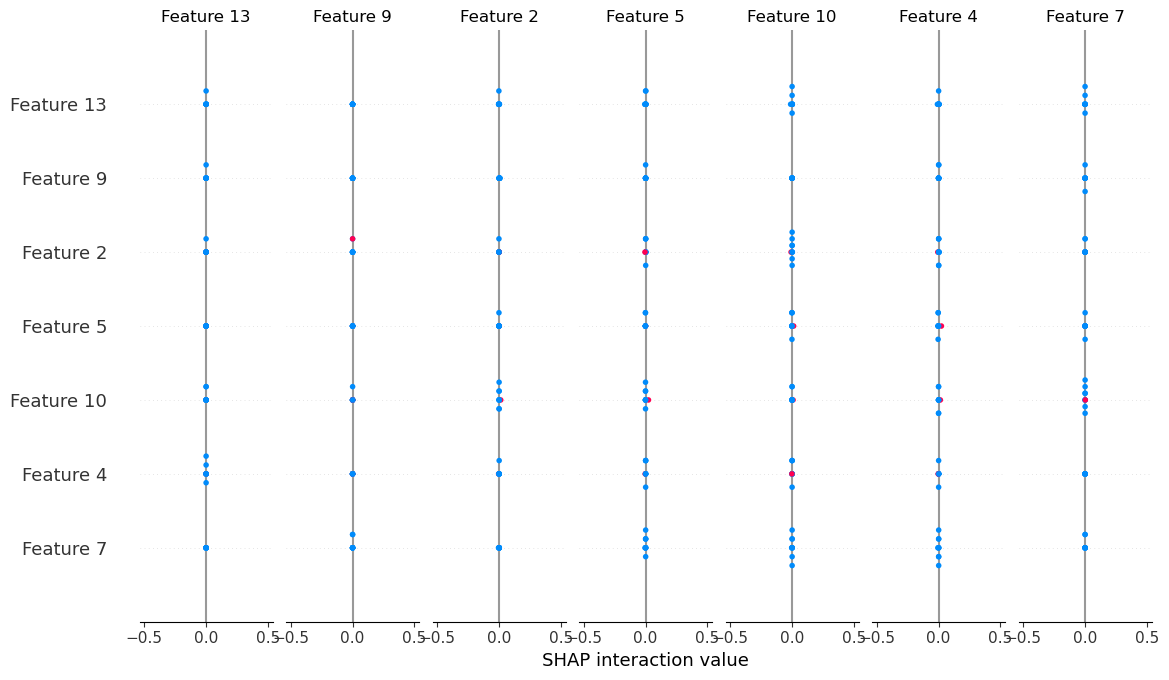

14 (10, 177, 14)


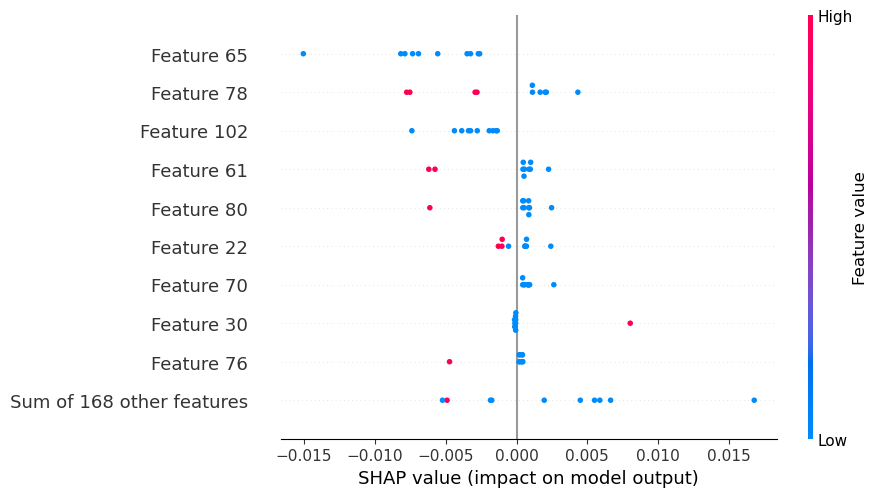

14 (10, 177, 14)


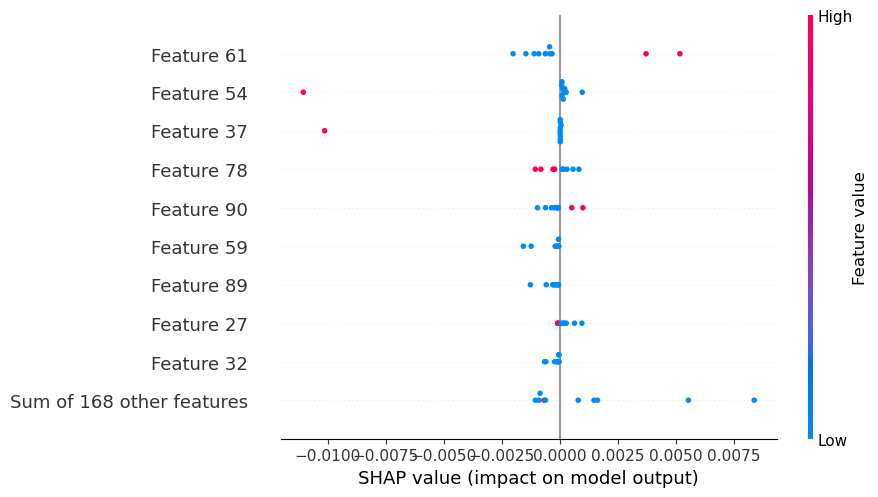

14 (10, 177, 14)


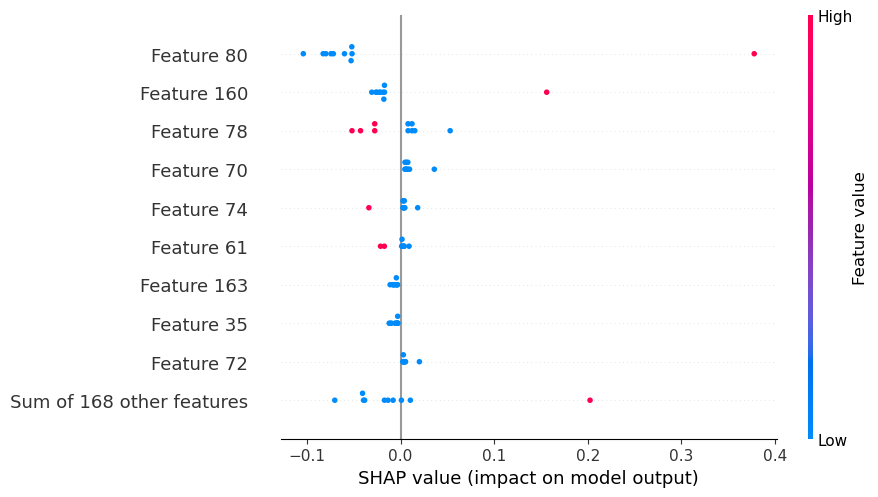

14 (10, 177, 14)


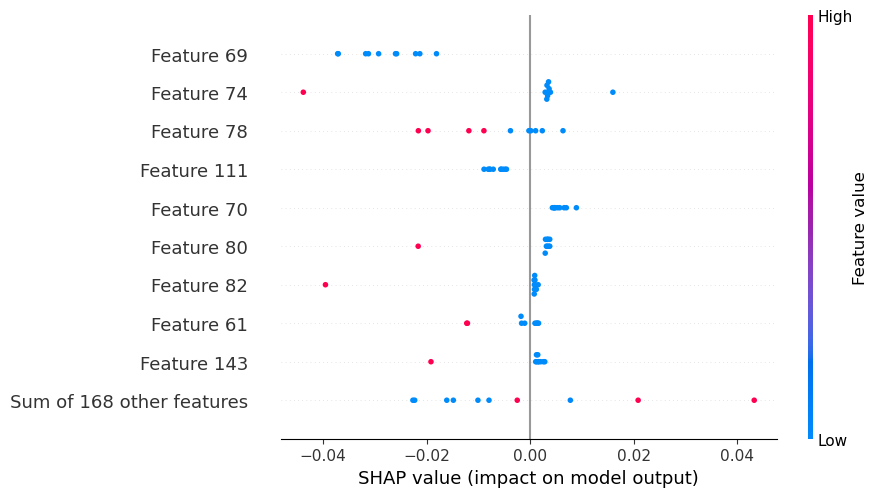

14 (10, 177, 14)


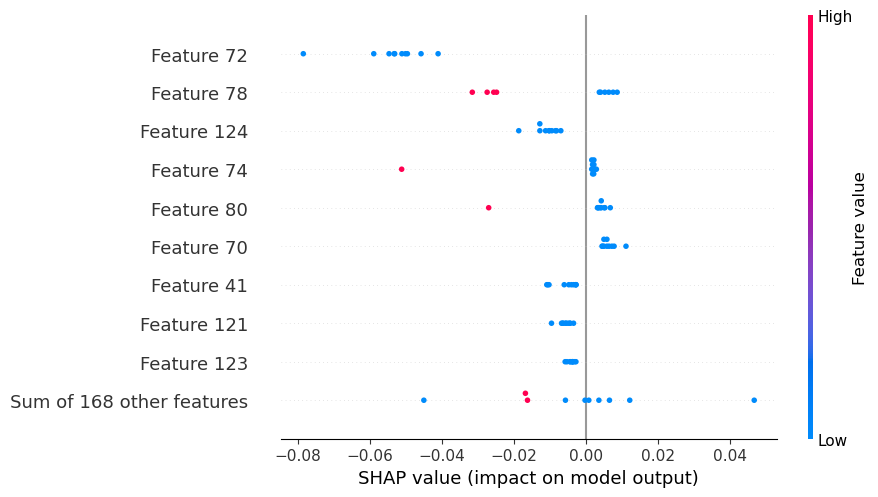

14 (10, 177, 14)


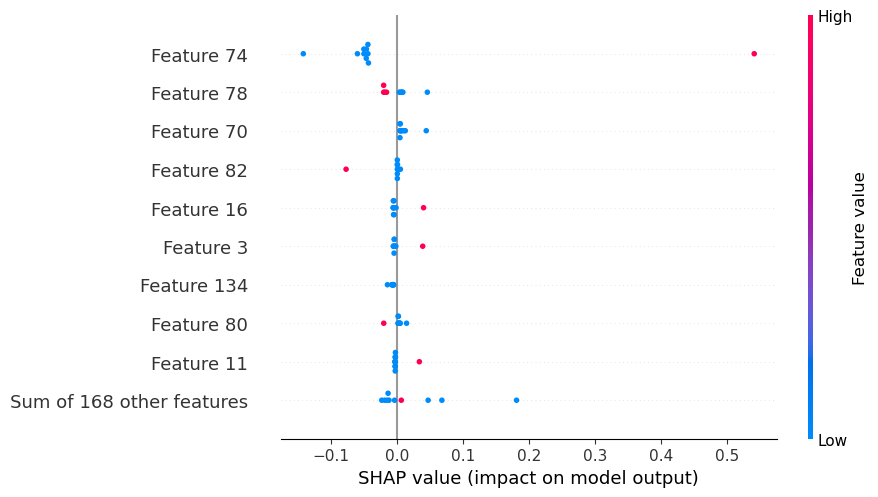

14 (10, 177, 14)


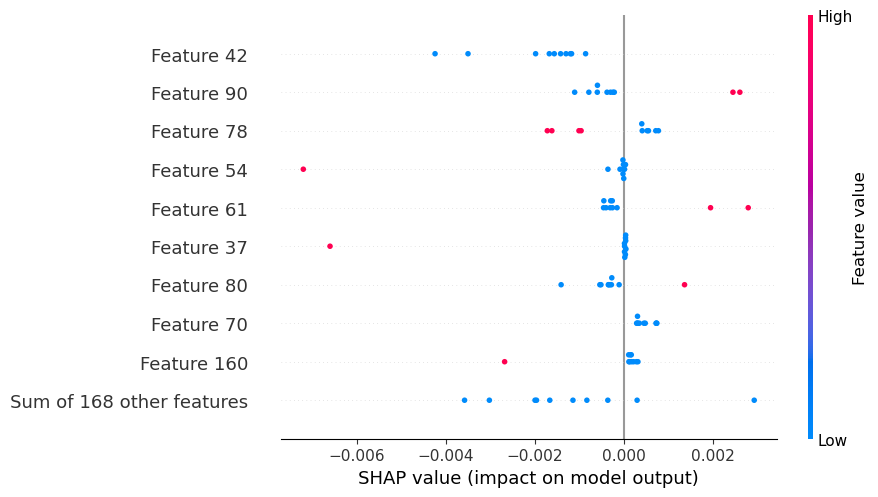

14 (10, 177, 14)


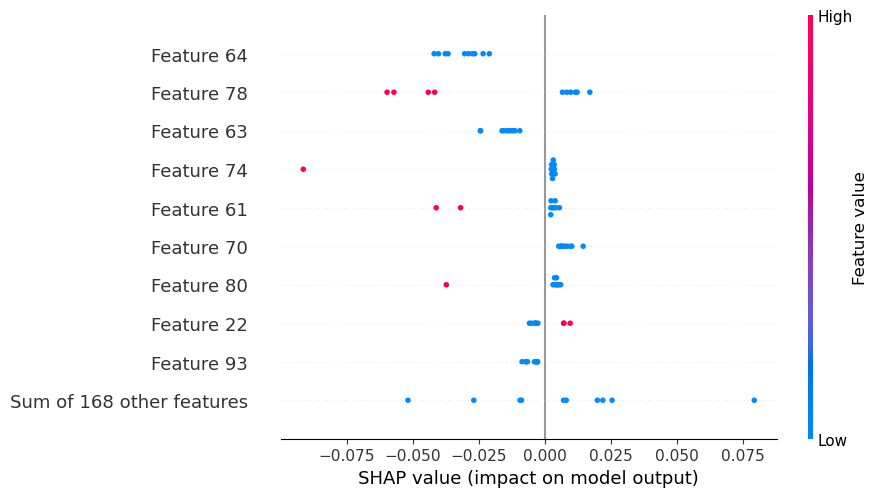

14 (10, 177, 14)


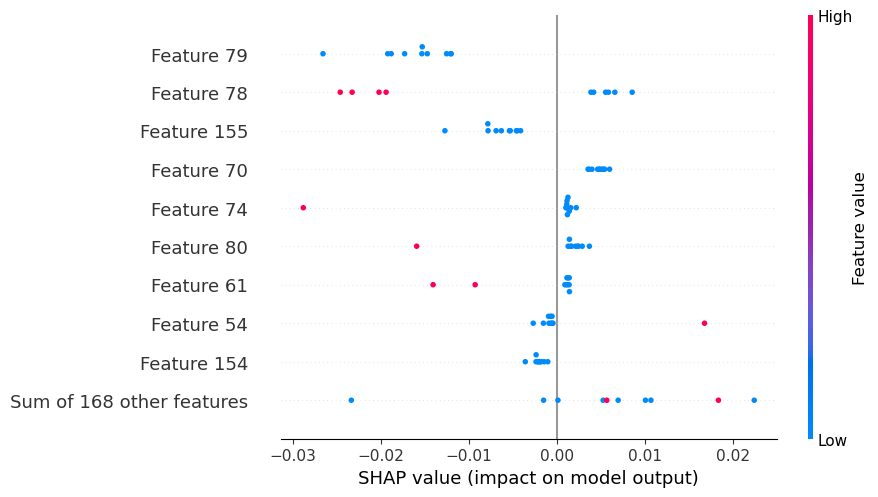

14 (10, 177, 14)


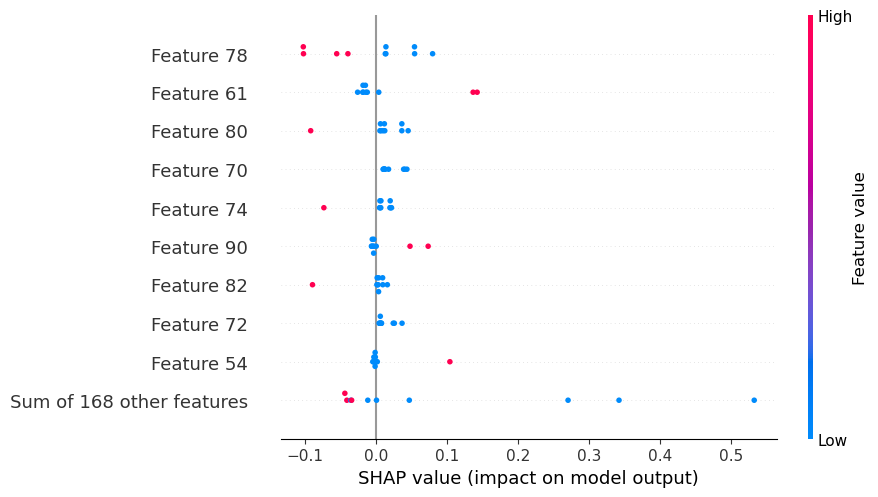

14 (10, 177, 14)


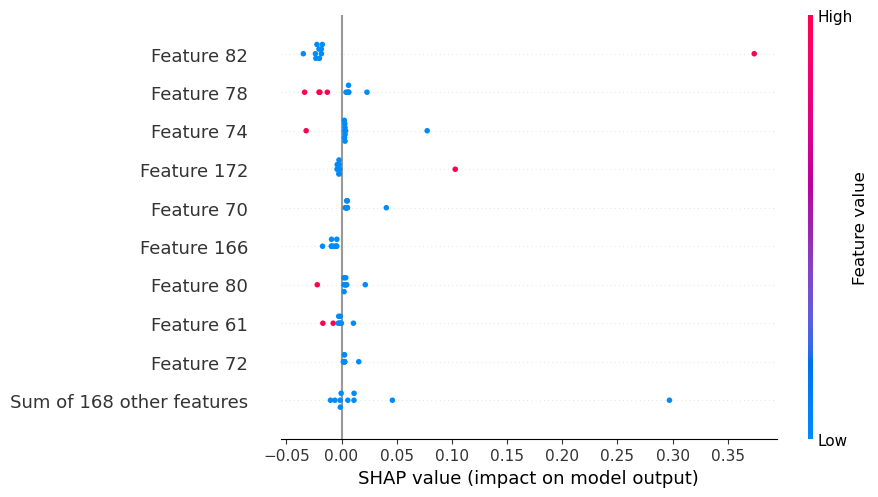

14 (10, 177, 14)


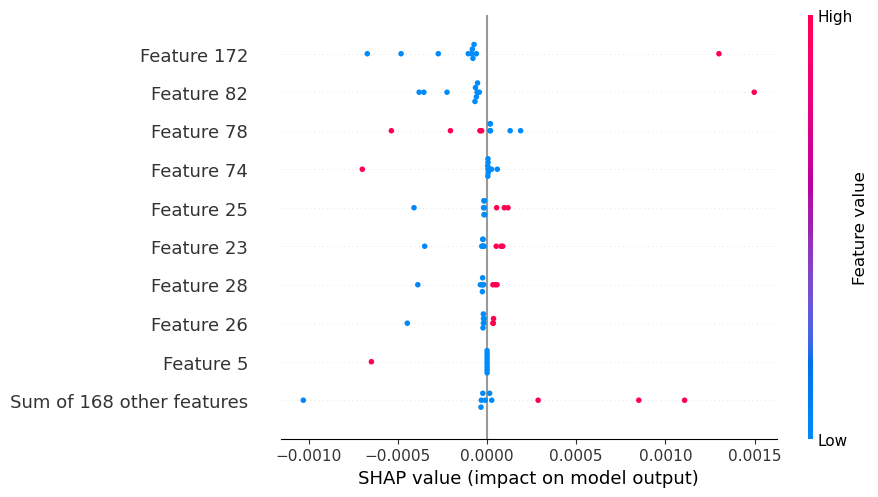

14 (10, 177, 14)


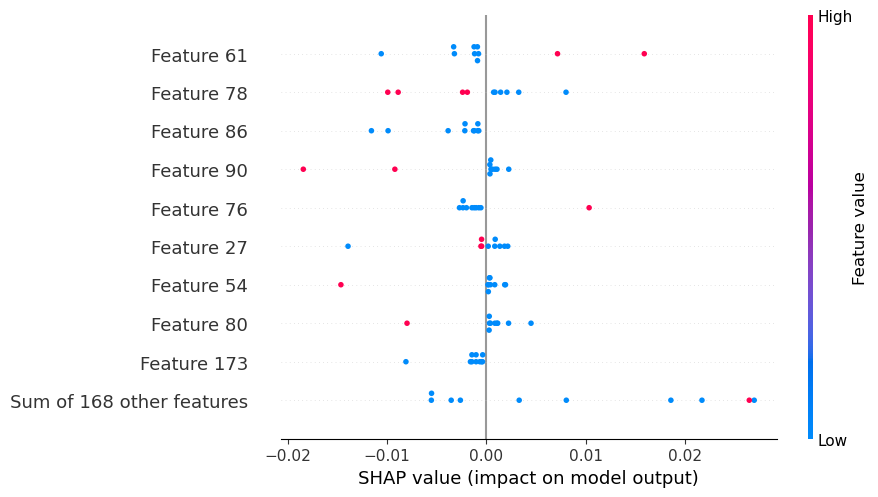

14 (10, 177, 14)


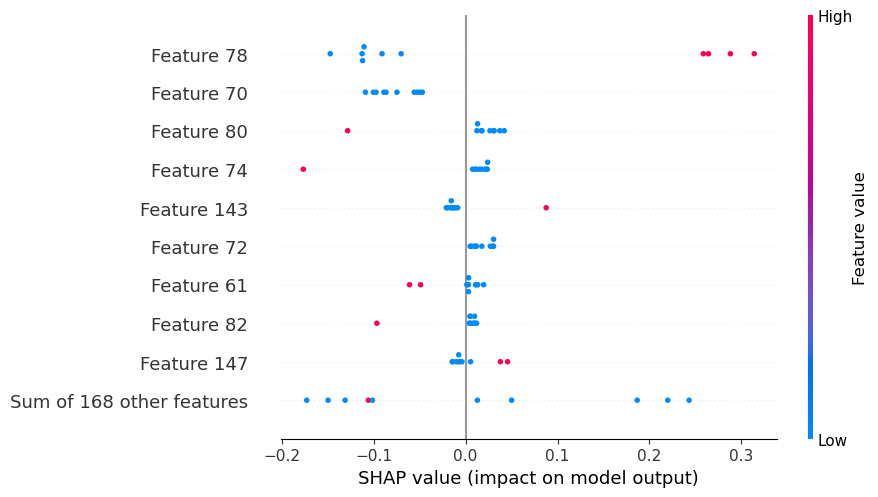

Metrics for SVC
Accuracy: 0.902321083172147
Precision: 0.9065357011670966
Recall: 0.902321083172147
F1-Score: 0.9001025277373389


<Figure size 640x480 with 0 Axes>

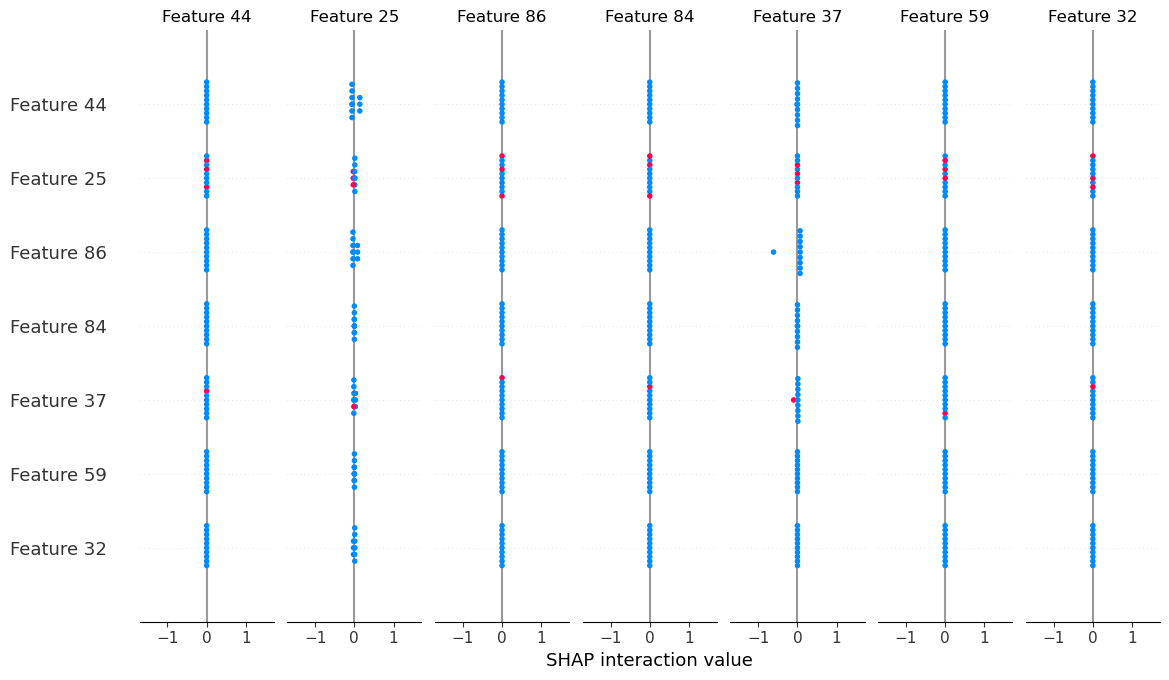

91 (10, 177, 91)


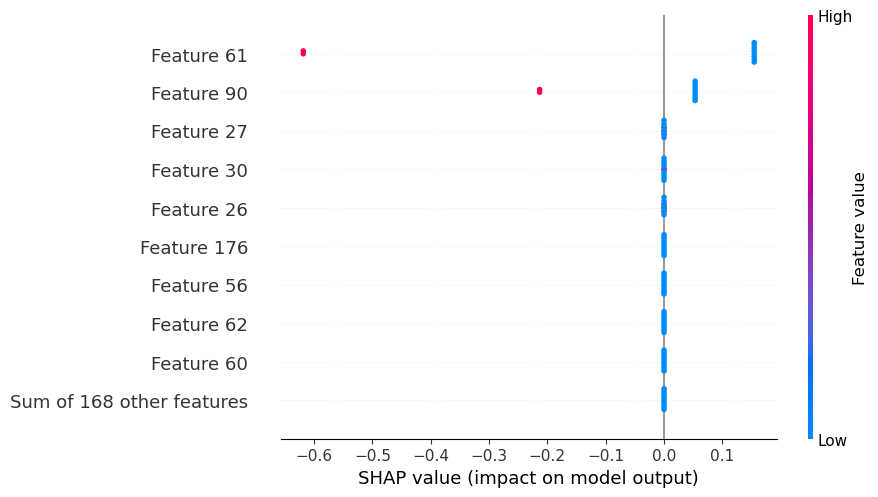

91 (10, 177, 91)


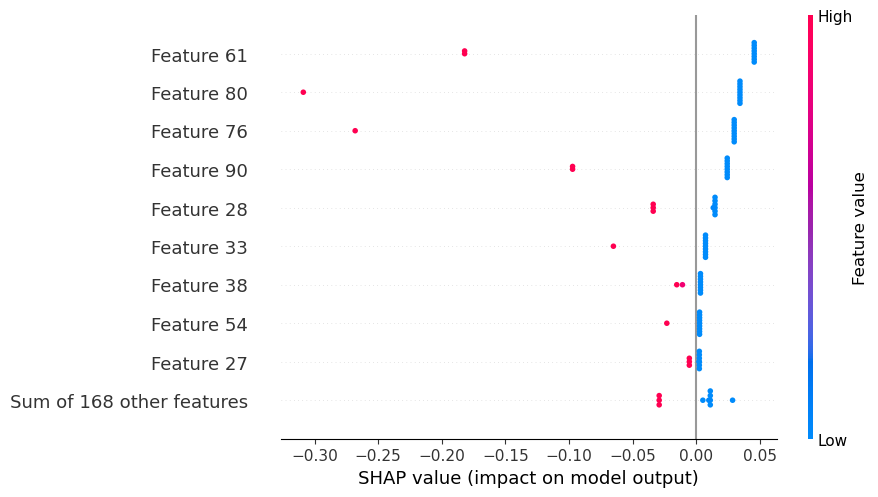

91 (10, 177, 91)


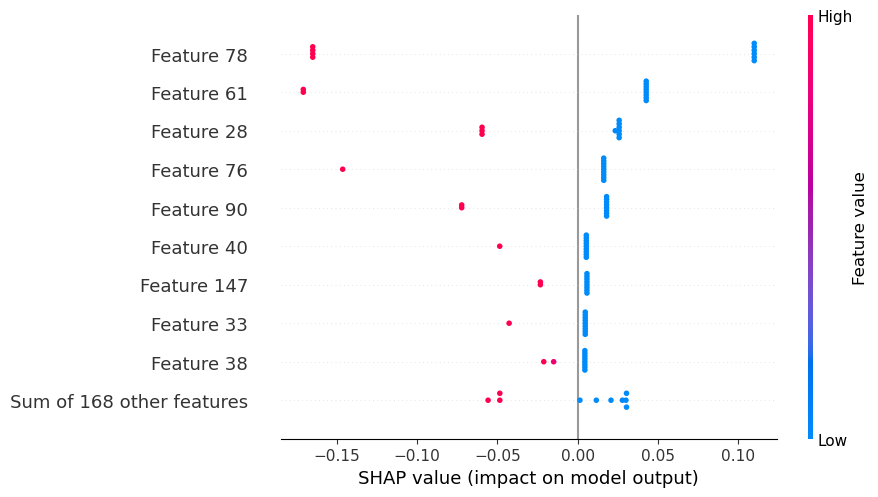

91 (10, 177, 91)


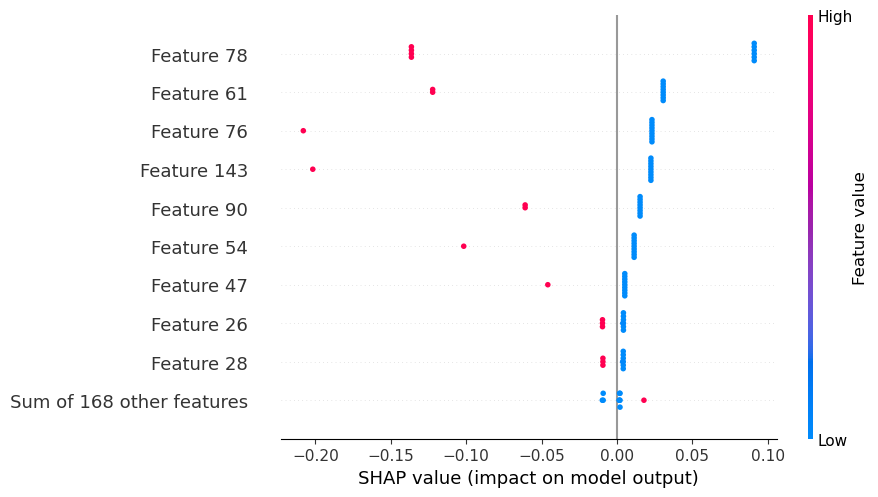

91 (10, 177, 91)


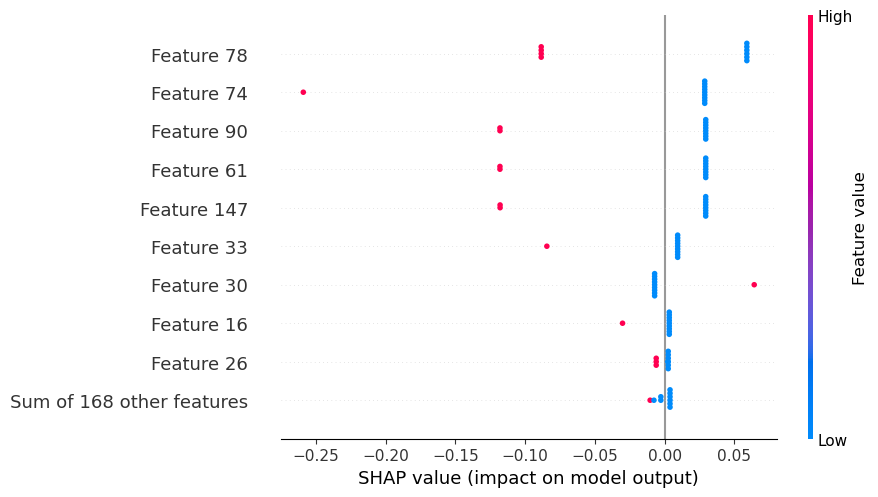

91 (10, 177, 91)


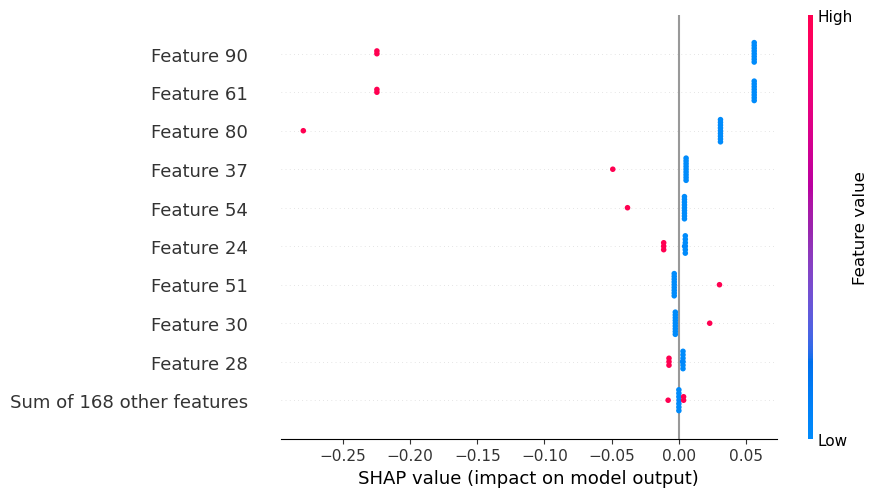

91 (10, 177, 91)


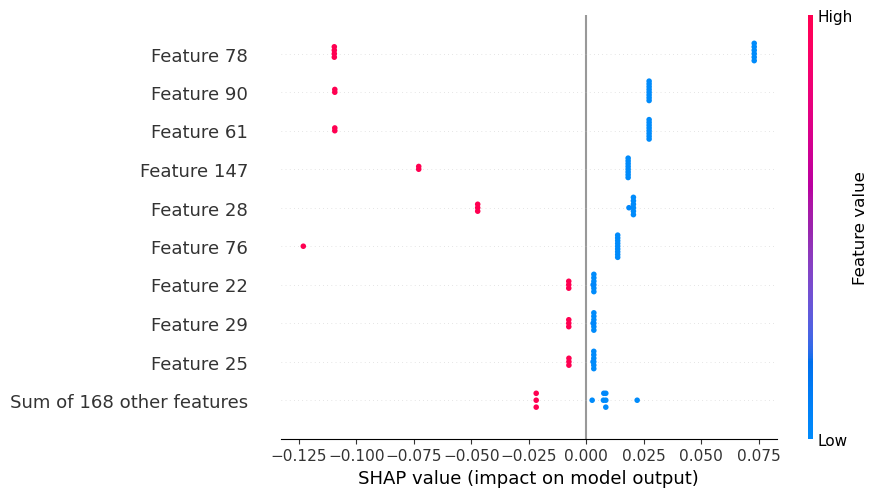

91 (10, 177, 91)


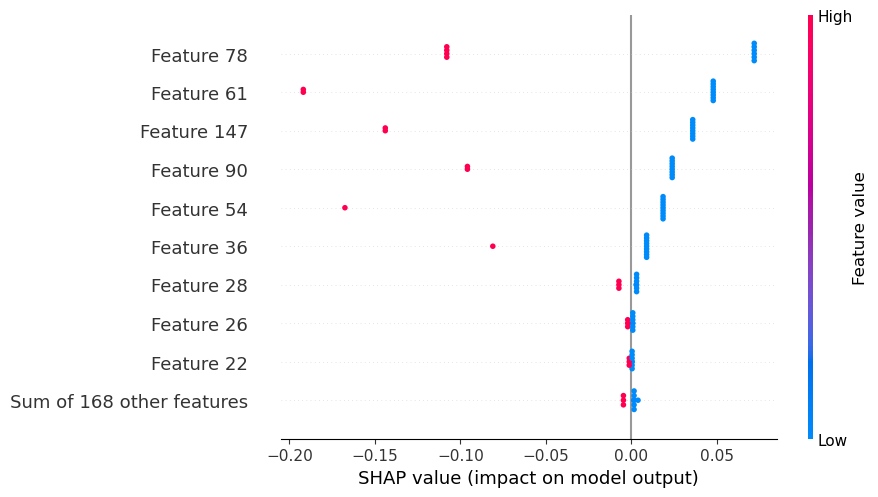

91 (10, 177, 91)


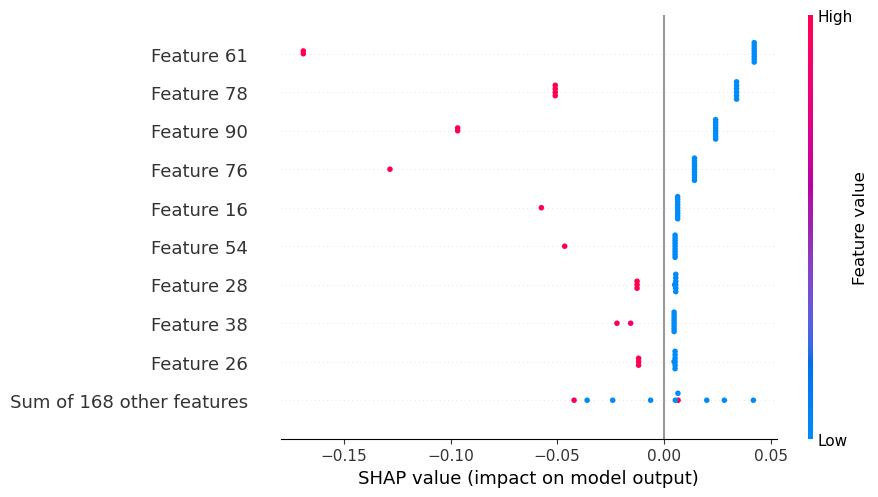

91 (10, 177, 91)


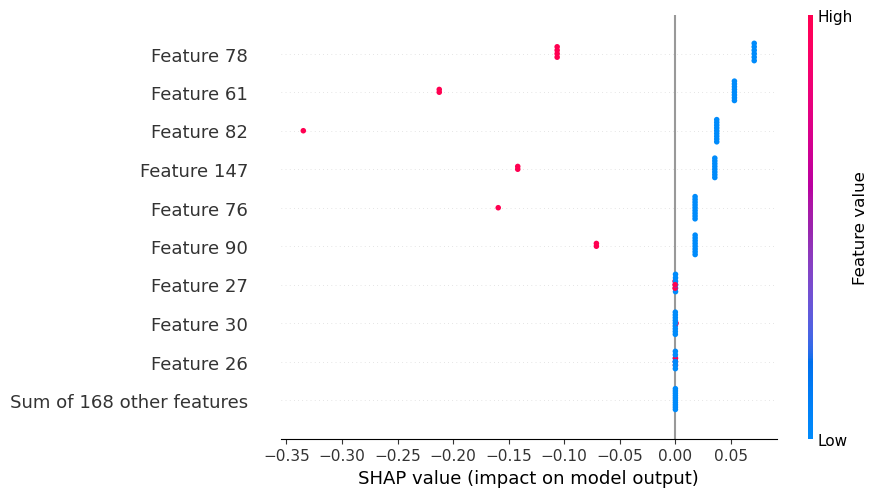

91 (10, 177, 91)


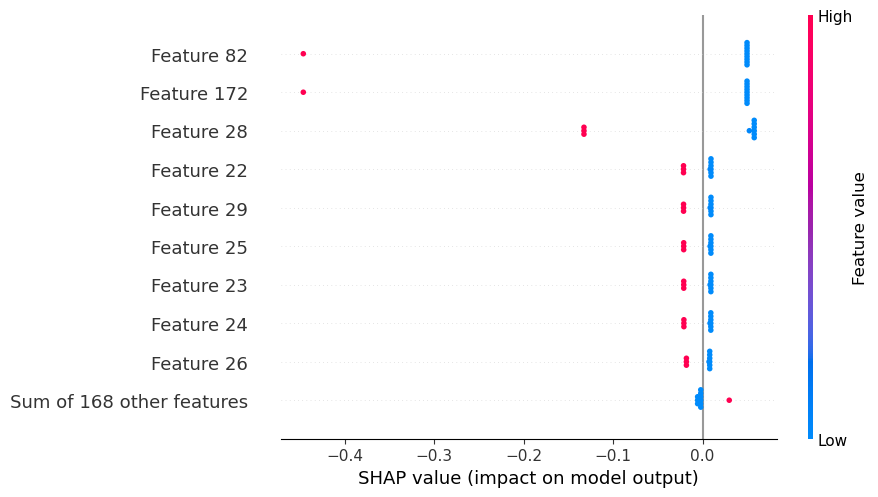

91 (10, 177, 91)


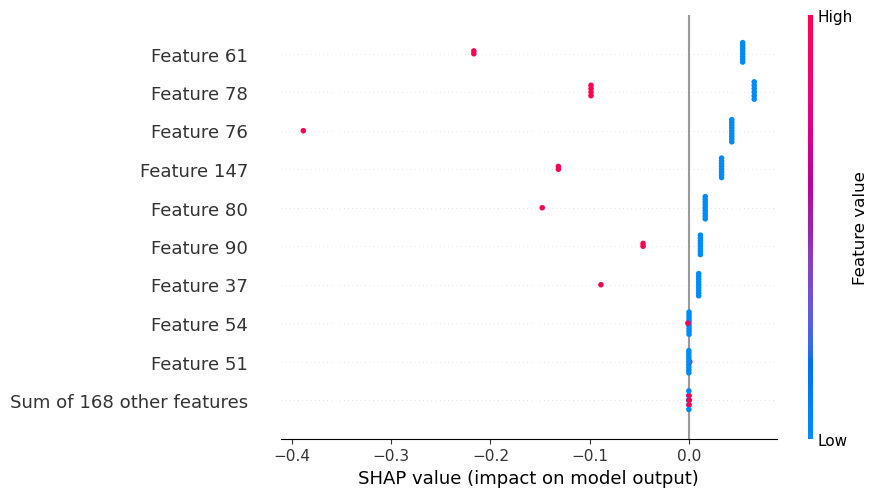

91 (10, 177, 91)


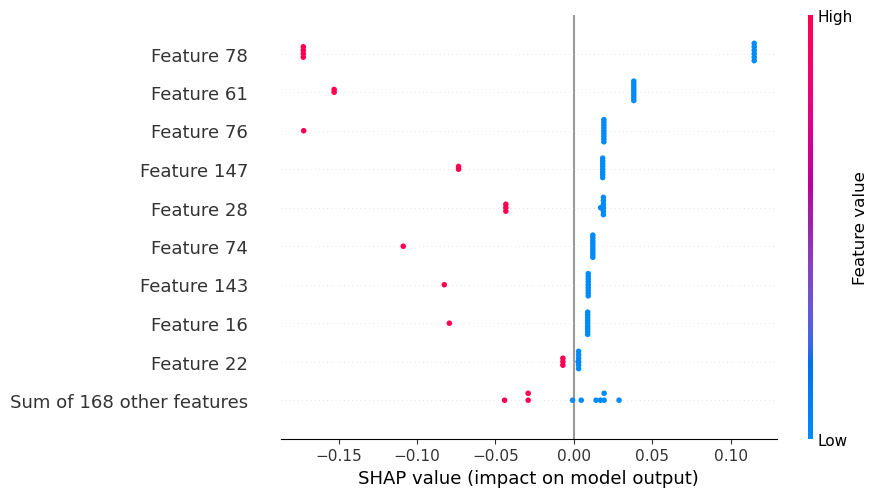

91 (10, 177, 91)


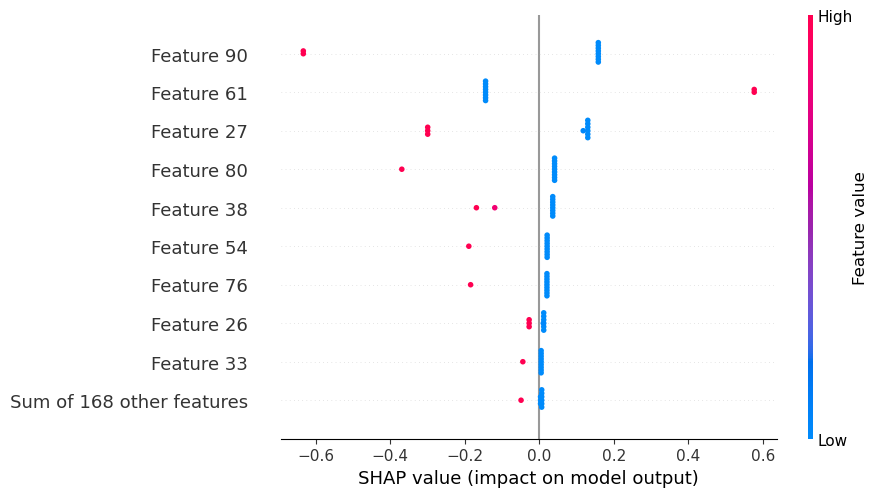

91 (10, 177, 91)


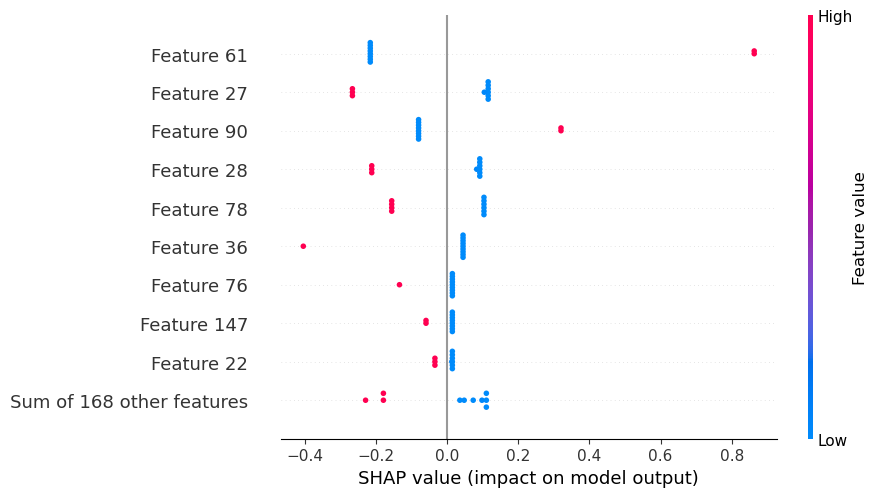

91 (10, 177, 91)


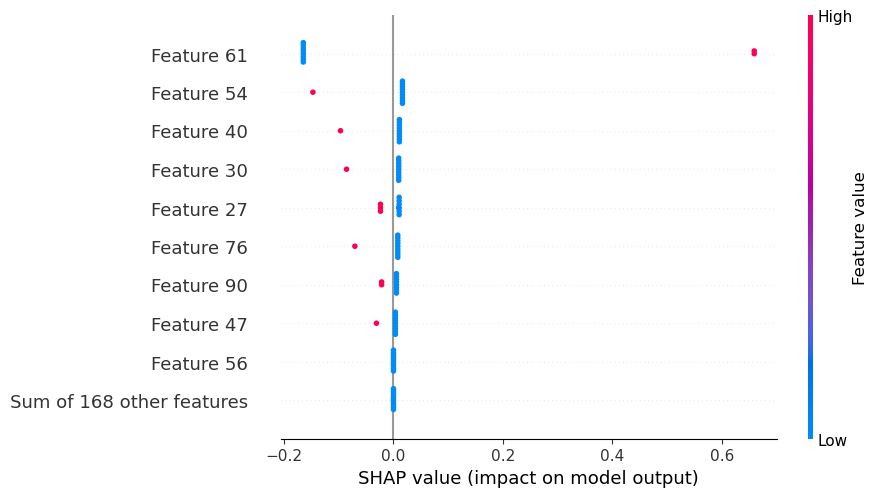

91 (10, 177, 91)


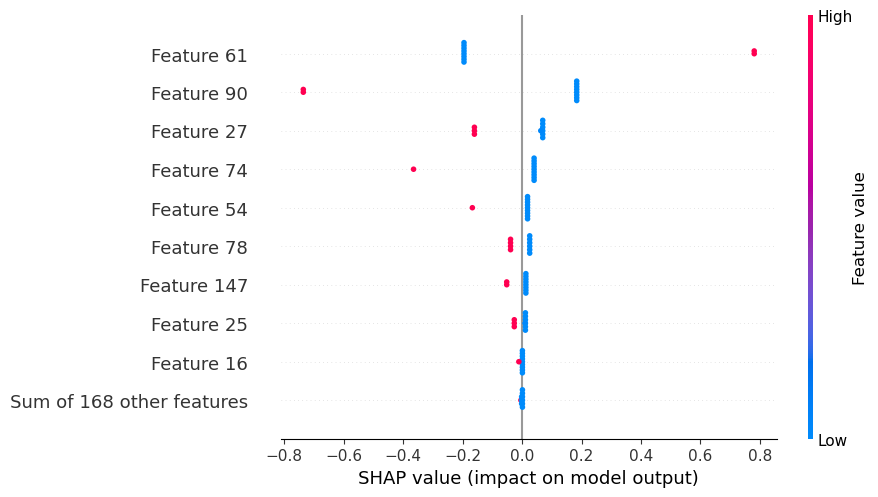

91 (10, 177, 91)


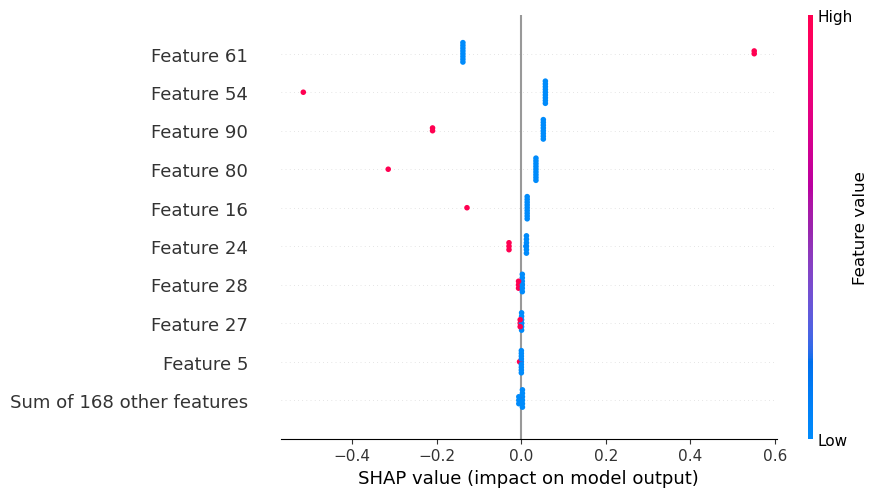

91 (10, 177, 91)


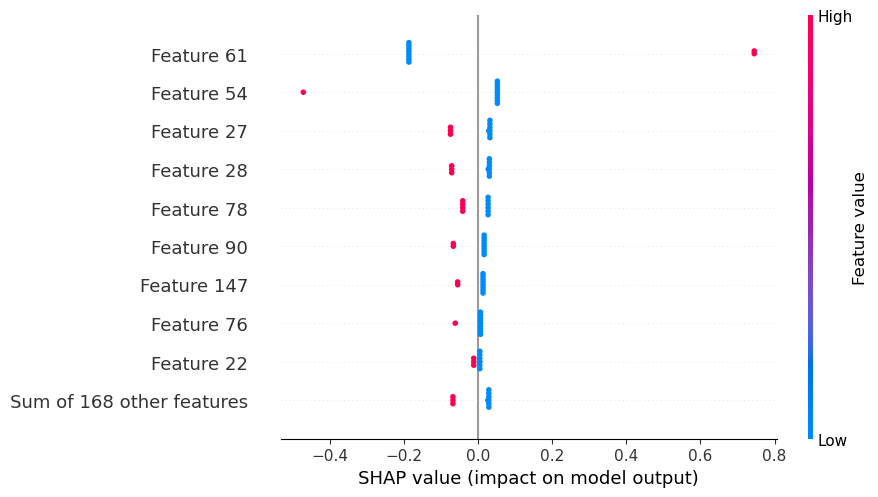

91 (10, 177, 91)


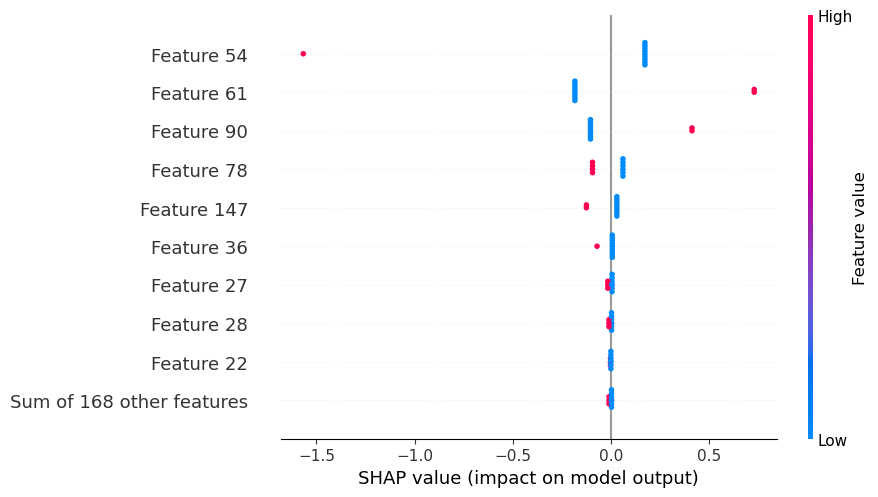

91 (10, 177, 91)


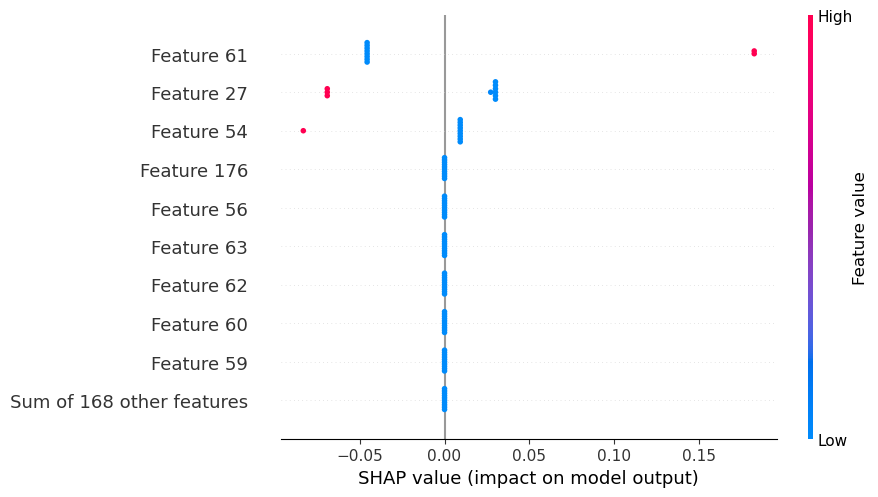

91 (10, 177, 91)


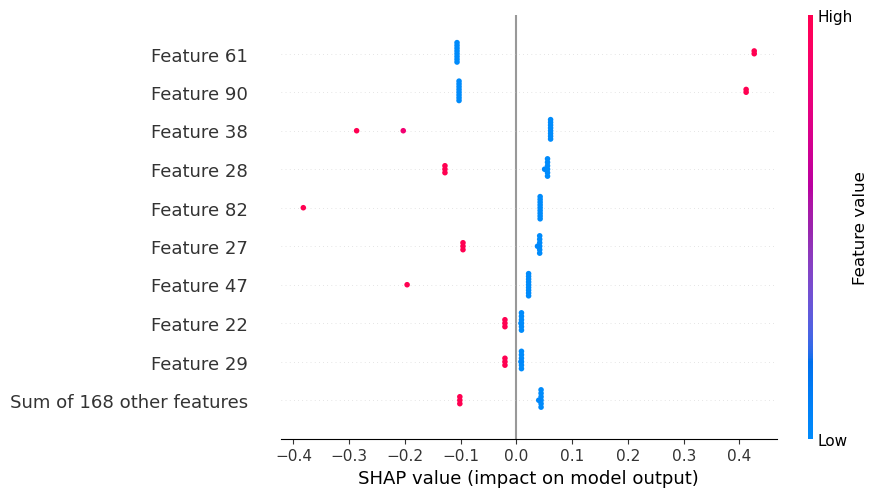

91 (10, 177, 91)


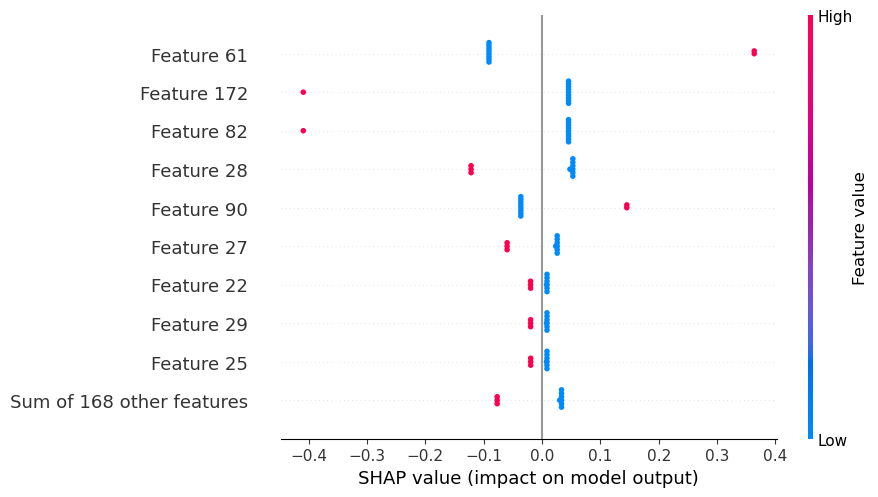

91 (10, 177, 91)


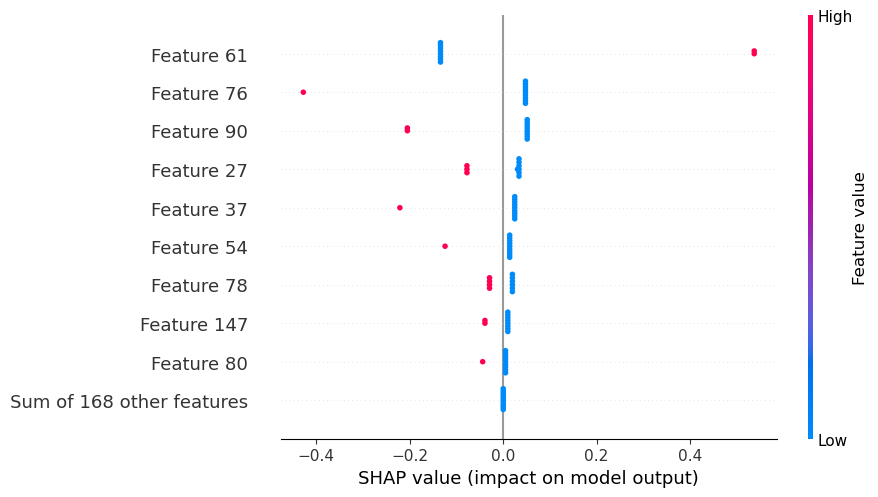

91 (10, 177, 91)


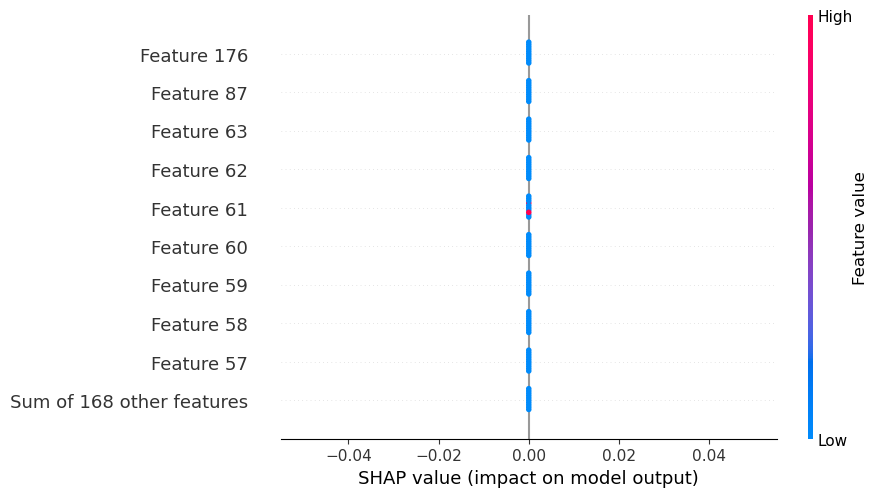

91 (10, 177, 91)


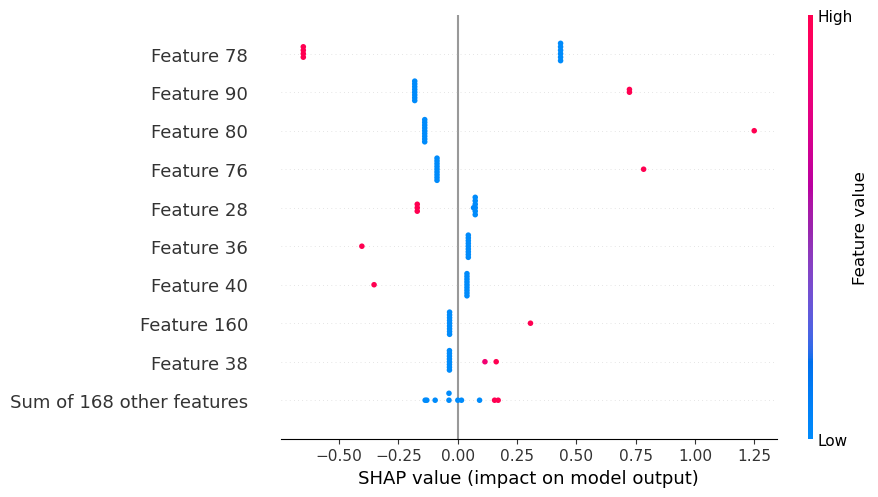

91 (10, 177, 91)


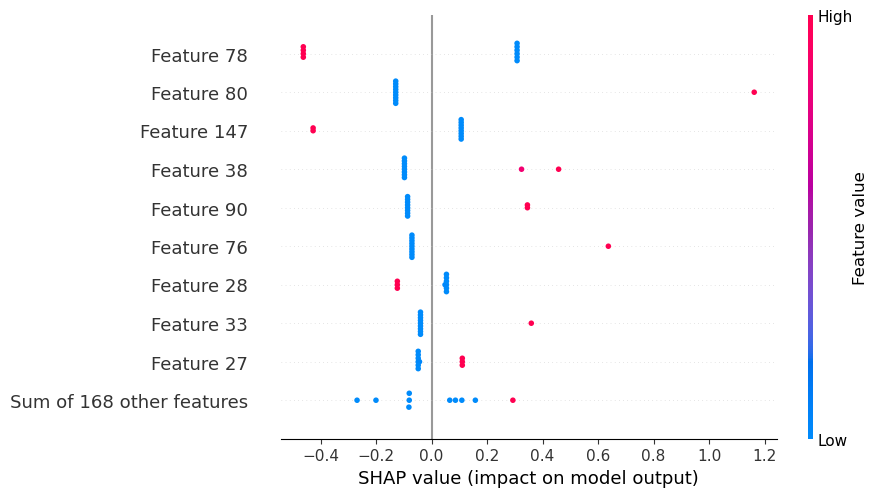

91 (10, 177, 91)


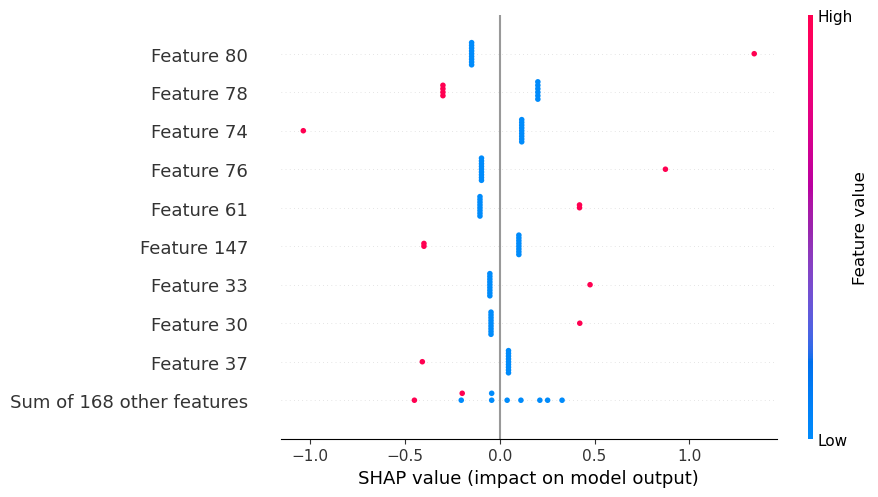

91 (10, 177, 91)


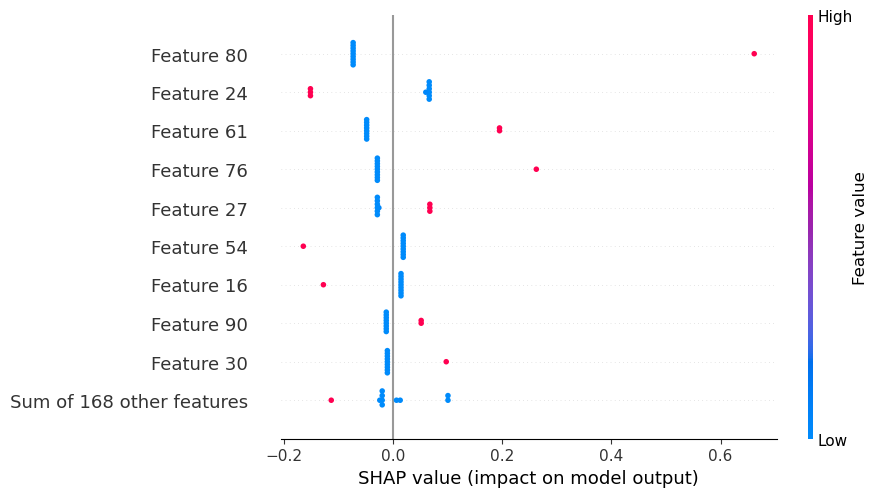

91 (10, 177, 91)


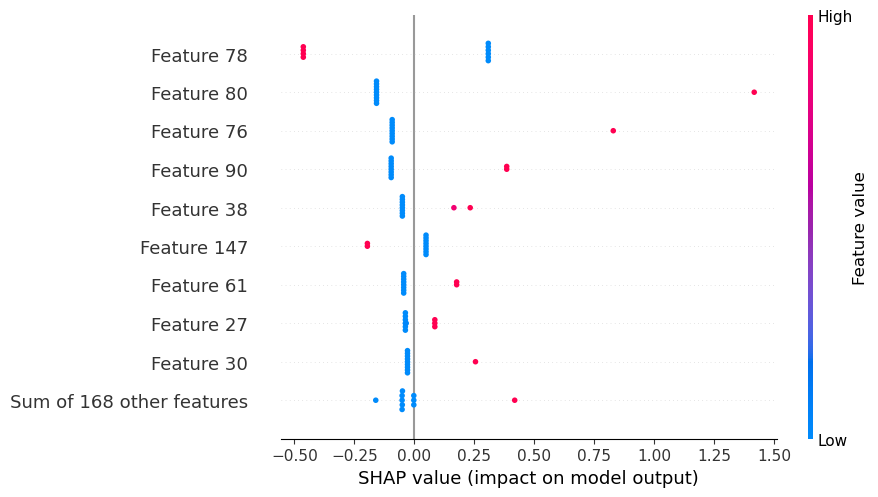

91 (10, 177, 91)


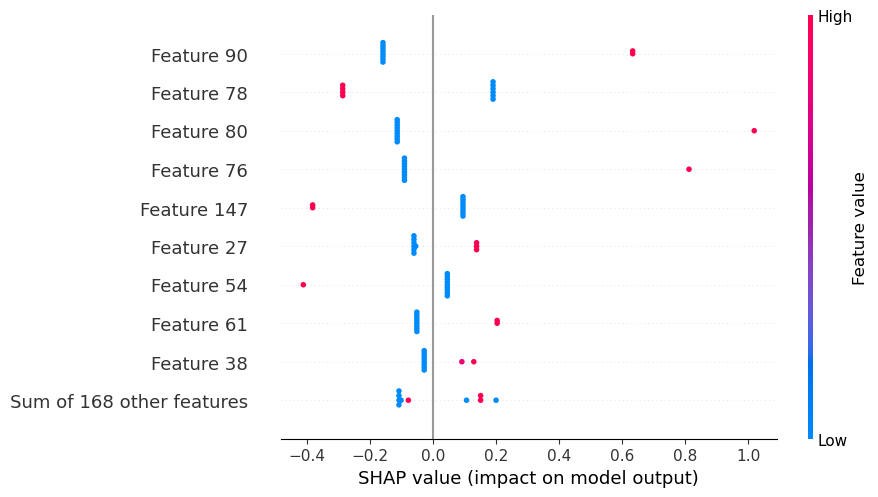

91 (10, 177, 91)


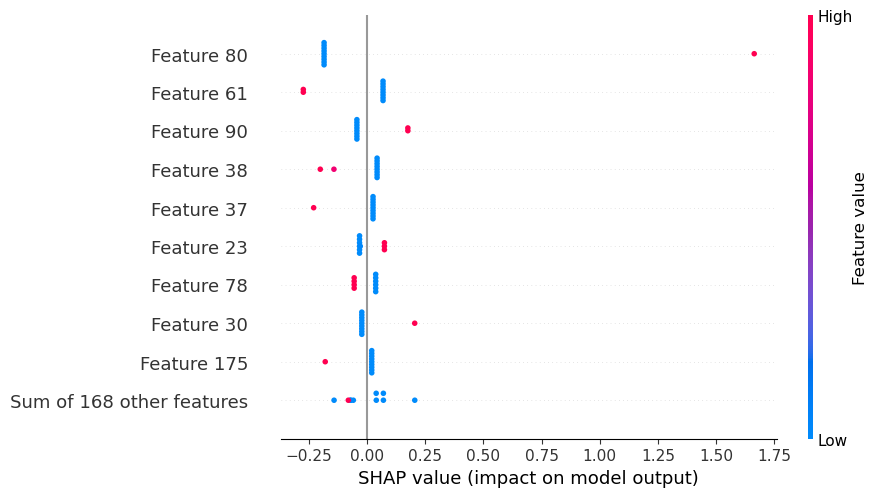

91 (10, 177, 91)


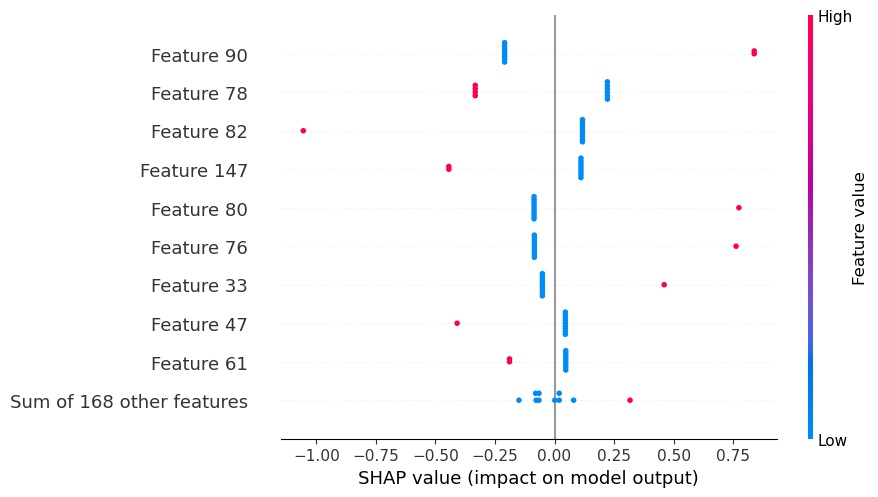

91 (10, 177, 91)


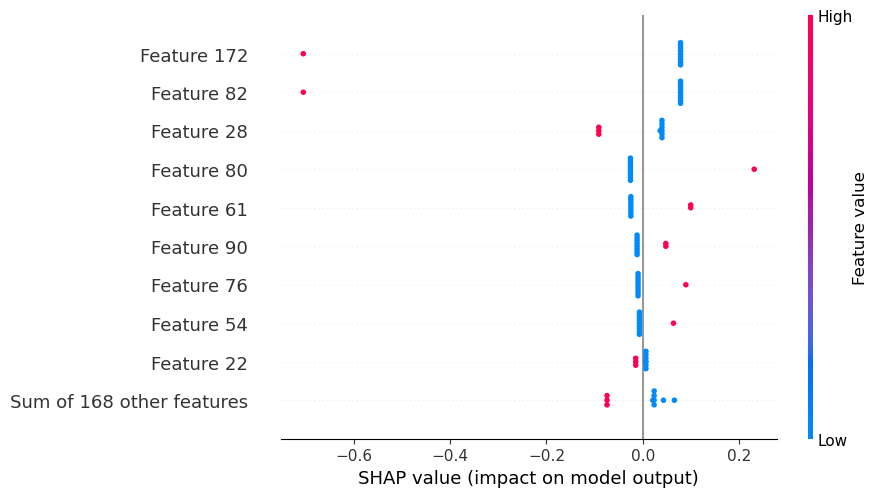

91 (10, 177, 91)


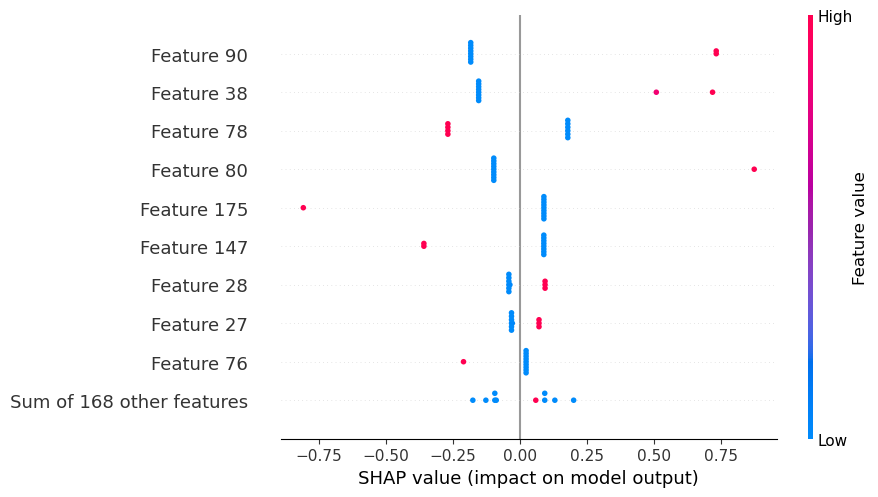

91 (10, 177, 91)


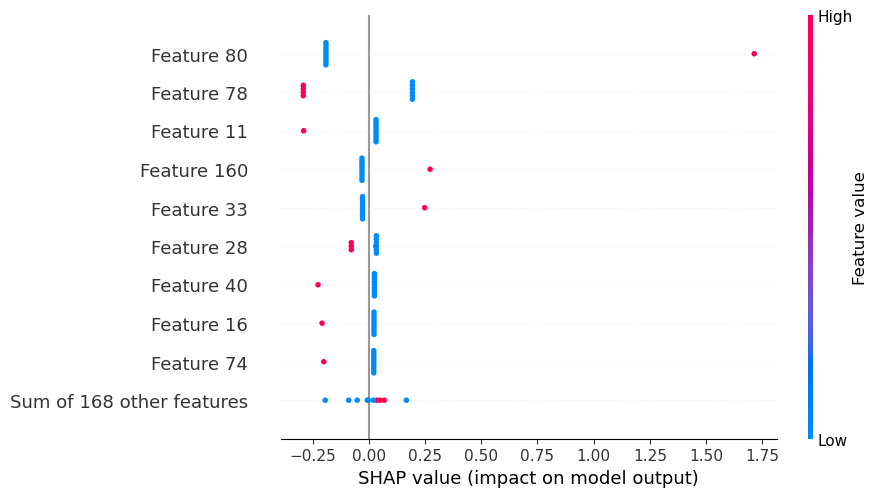

91 (10, 177, 91)


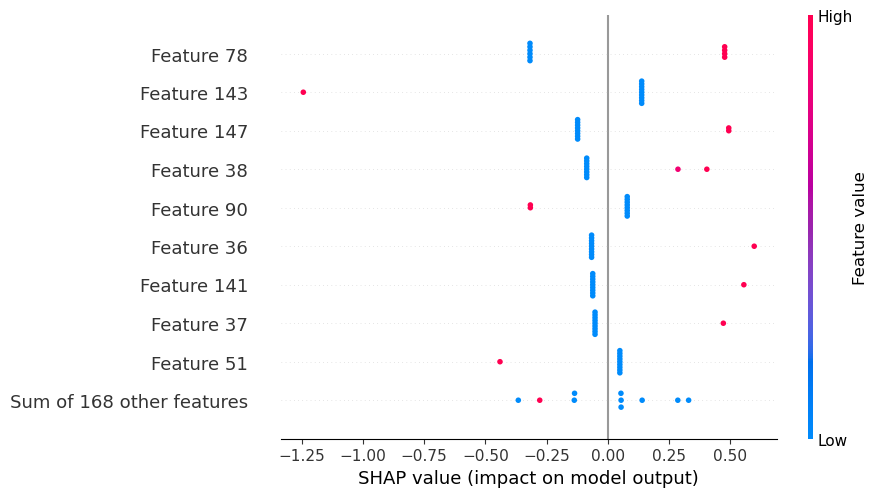

91 (10, 177, 91)


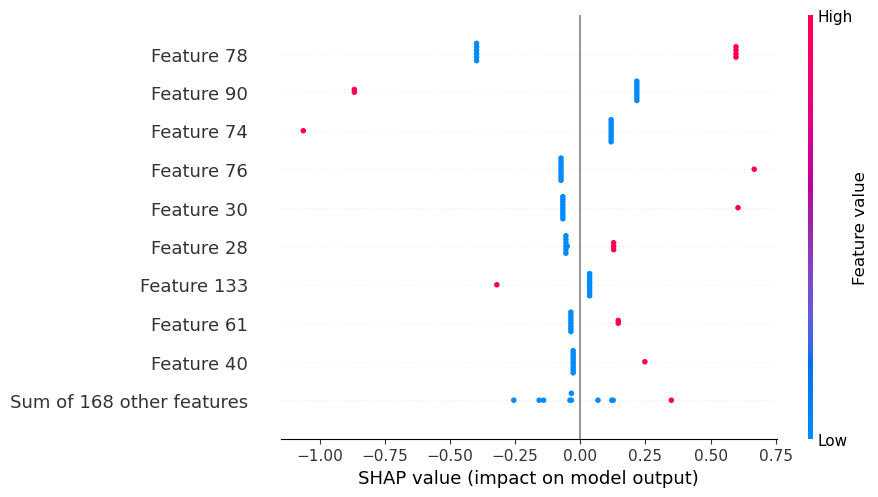

91 (10, 177, 91)


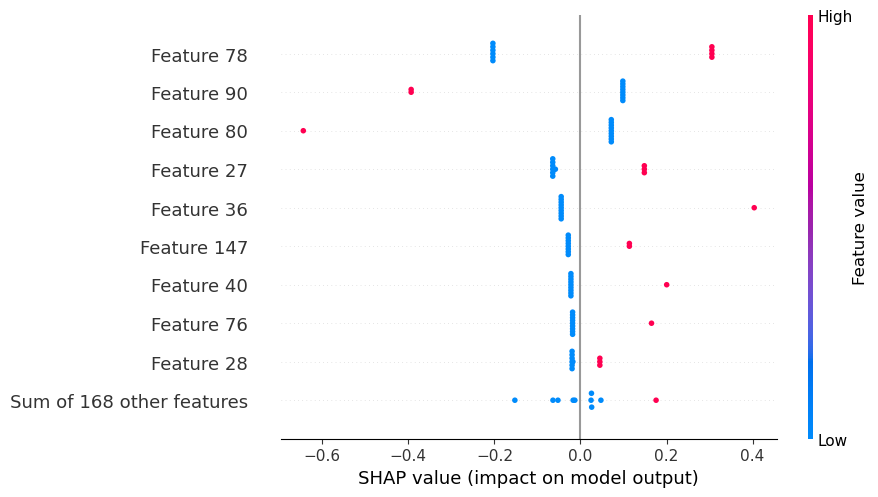

91 (10, 177, 91)


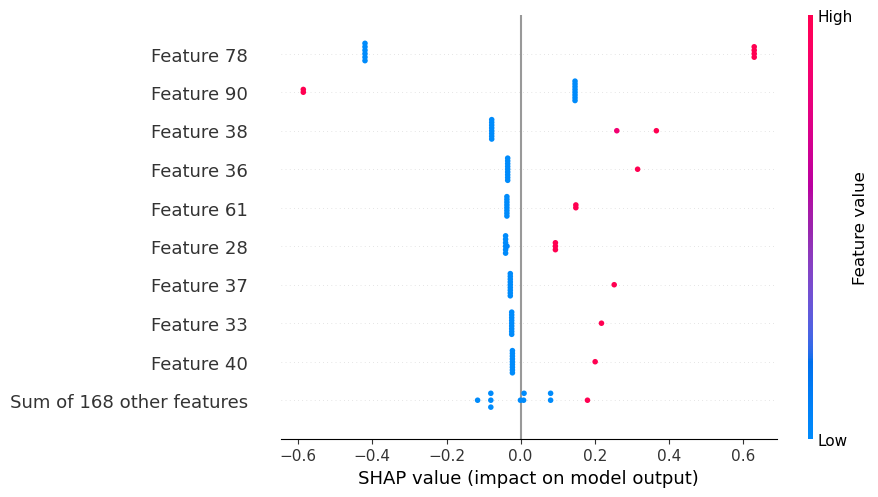

91 (10, 177, 91)


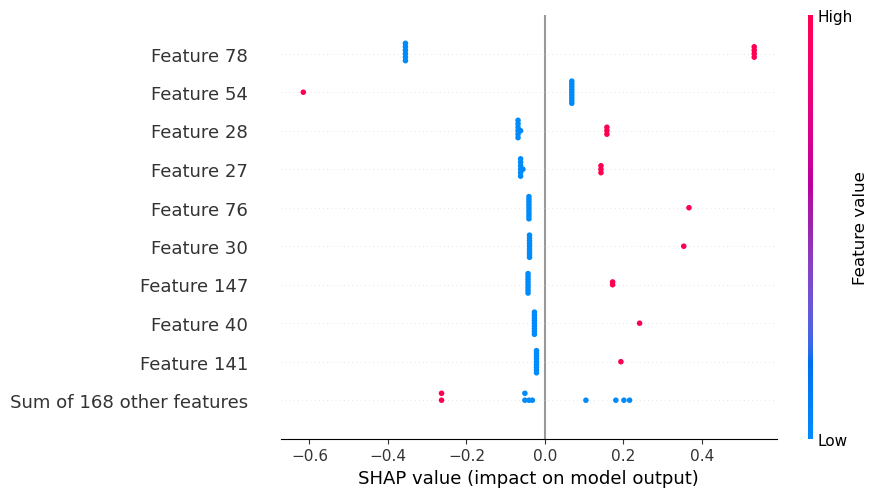

91 (10, 177, 91)


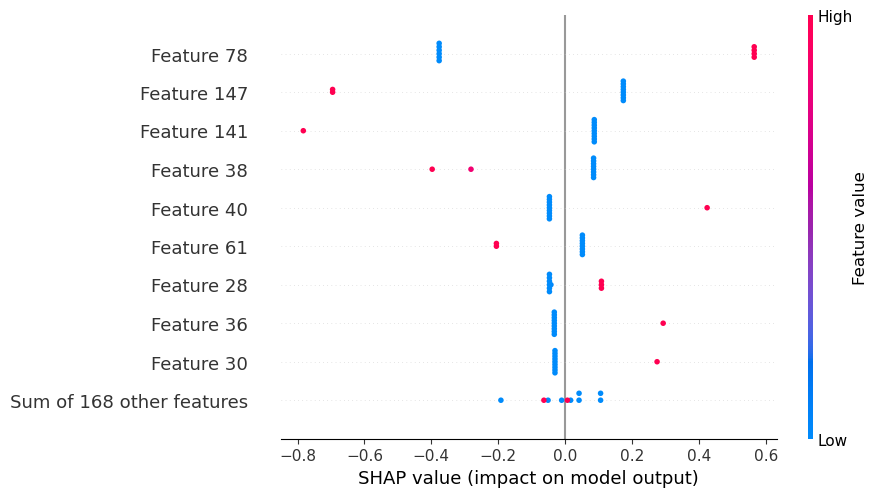

91 (10, 177, 91)


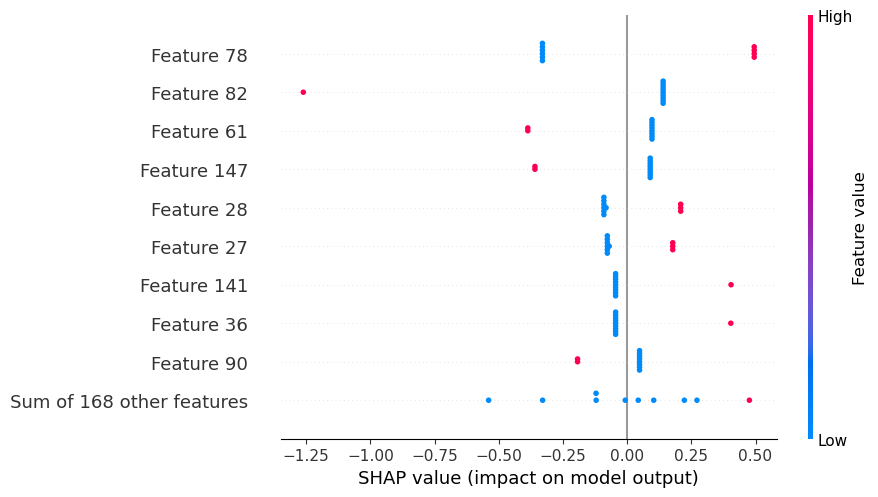

91 (10, 177, 91)


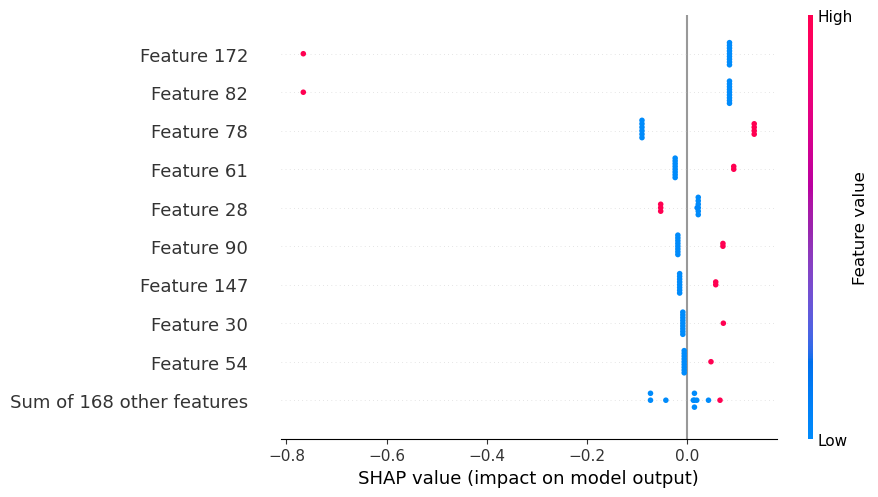

91 (10, 177, 91)


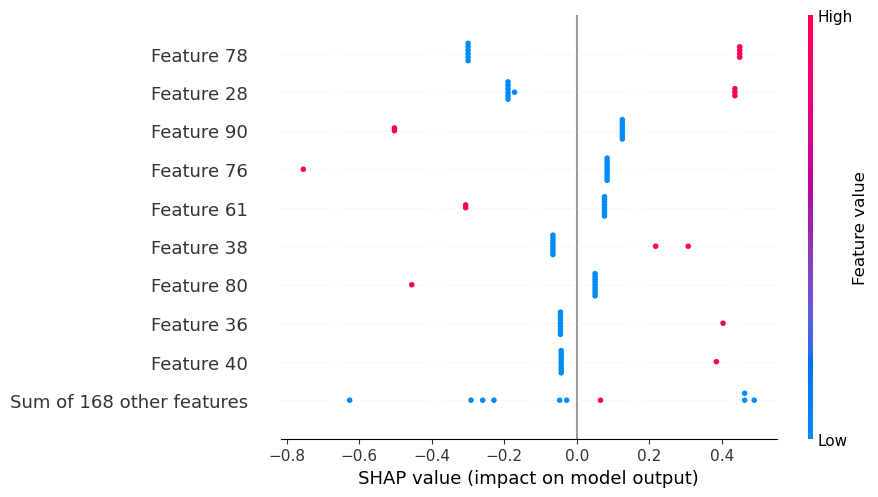

91 (10, 177, 91)


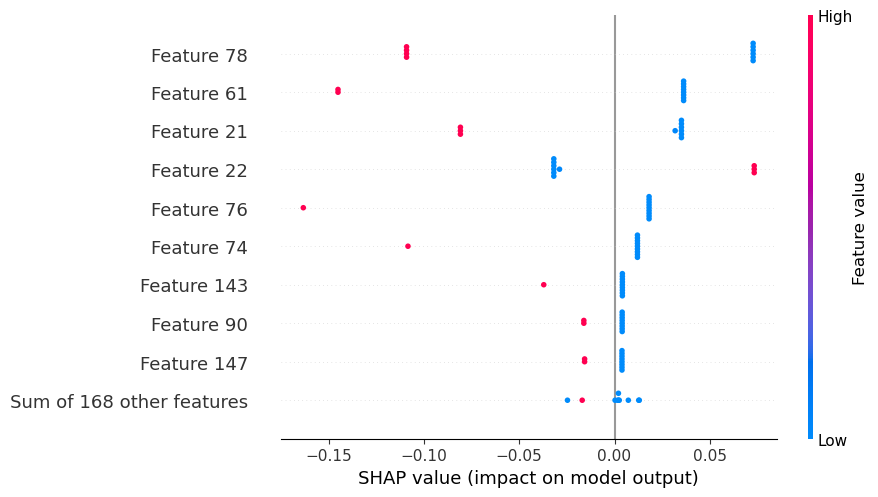

91 (10, 177, 91)


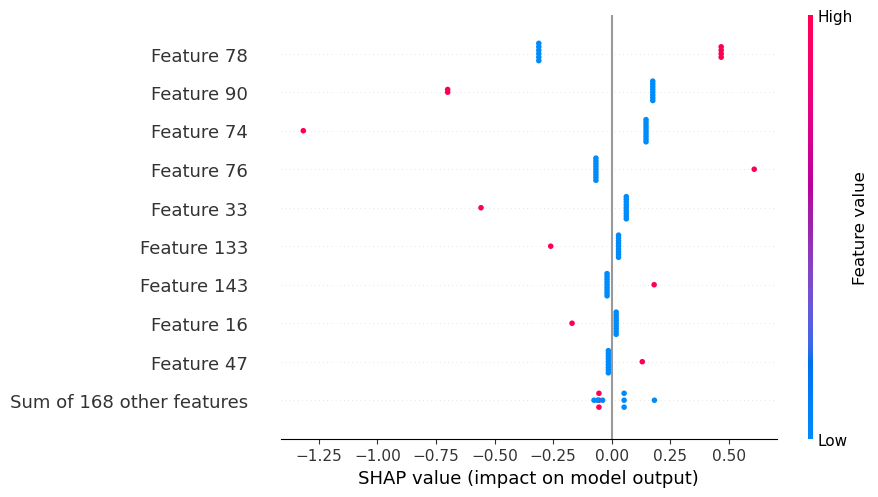

91 (10, 177, 91)


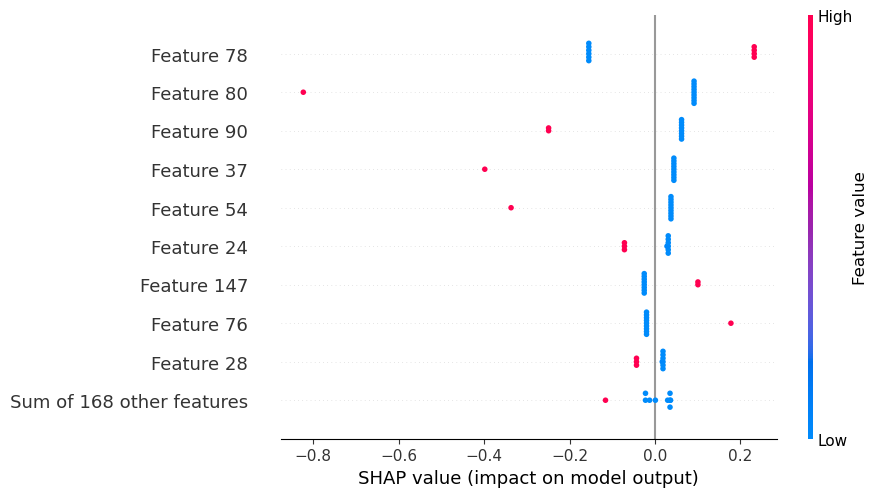

91 (10, 177, 91)


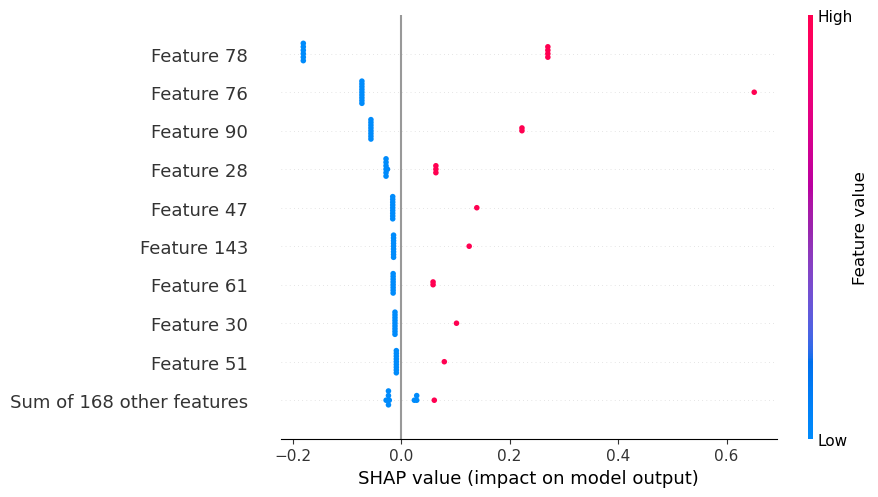

91 (10, 177, 91)


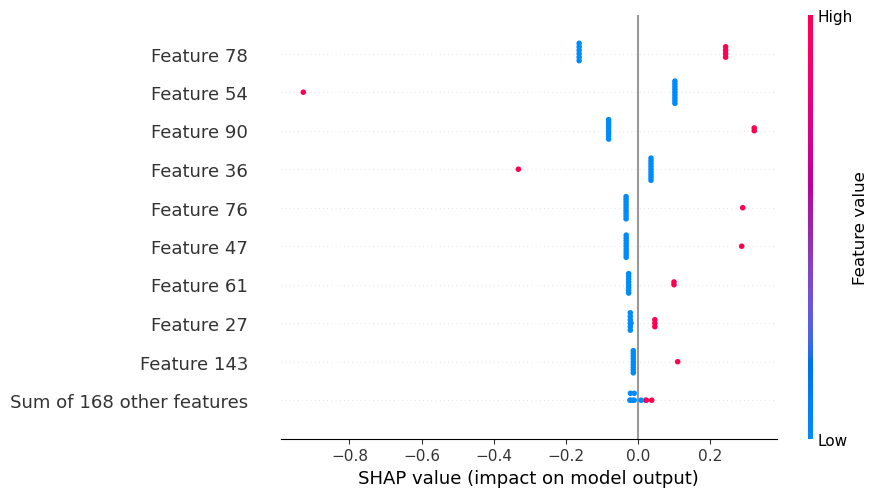

91 (10, 177, 91)


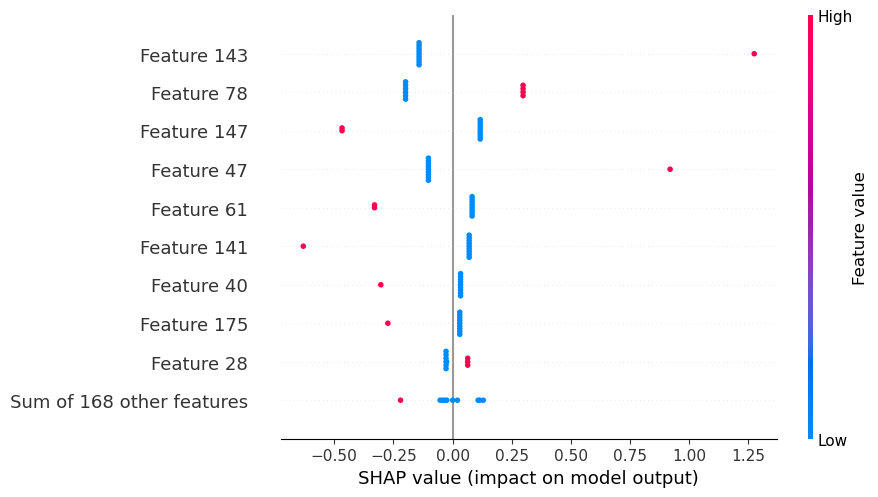

91 (10, 177, 91)


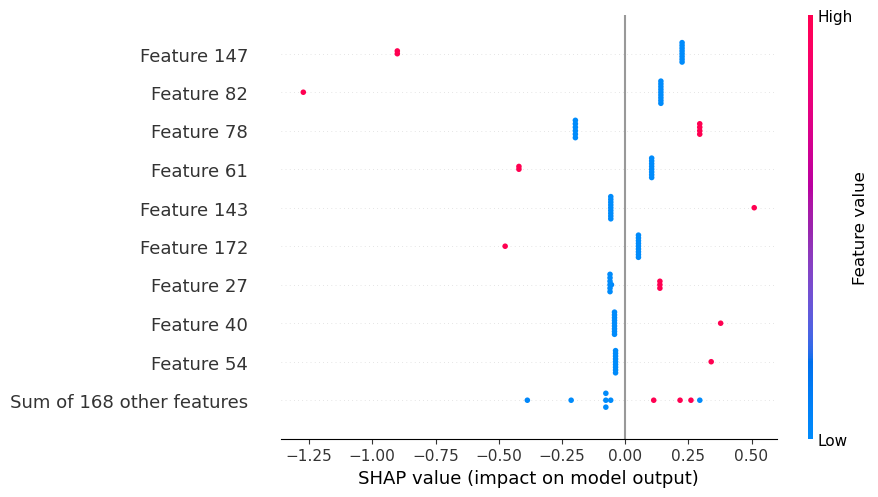

91 (10, 177, 91)


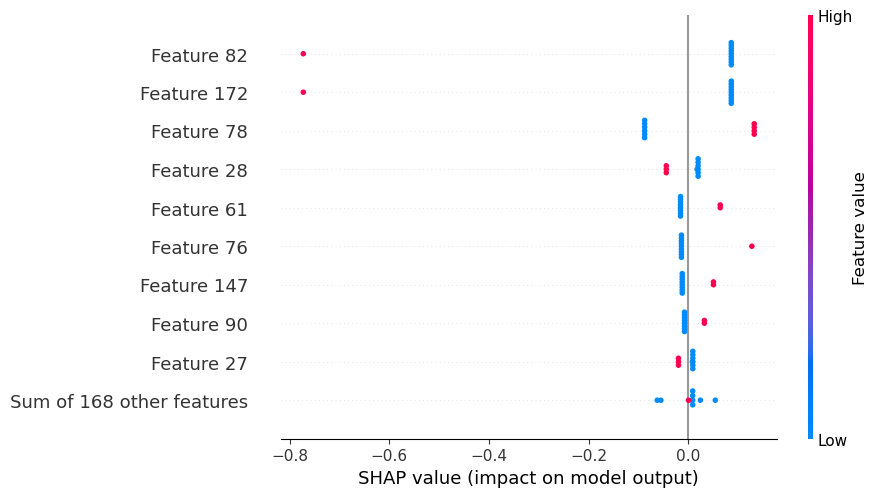

91 (10, 177, 91)


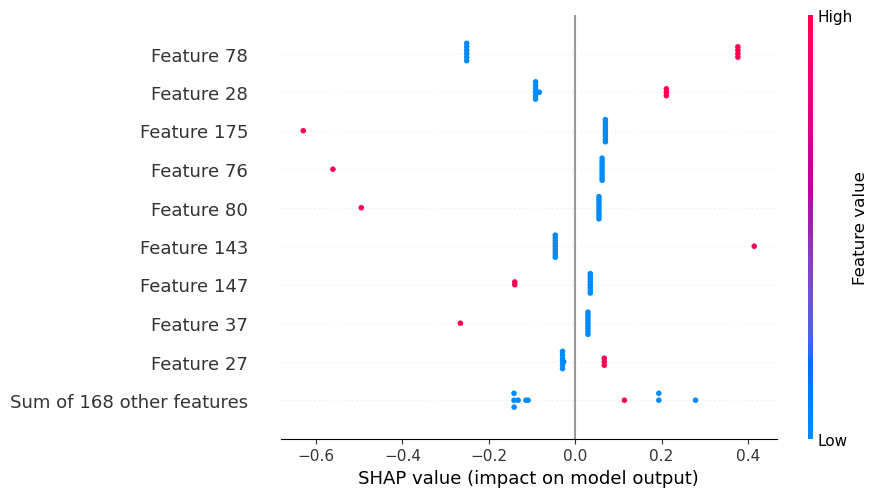

91 (10, 177, 91)


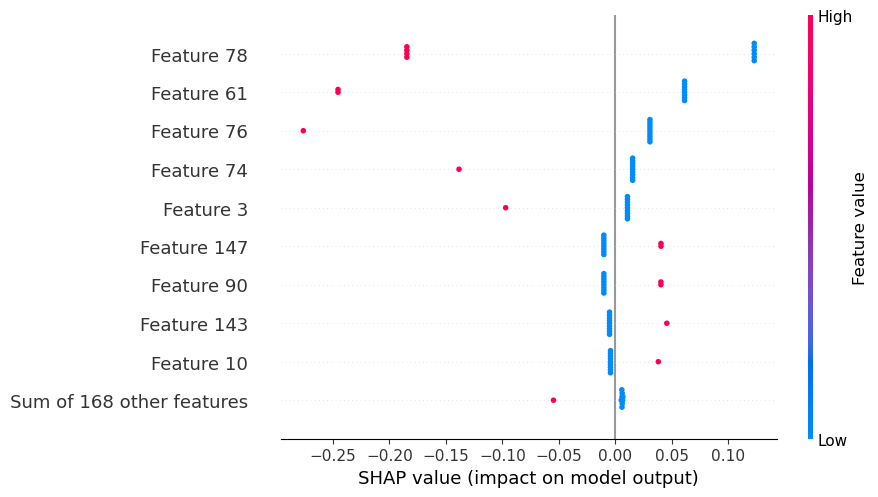

91 (10, 177, 91)


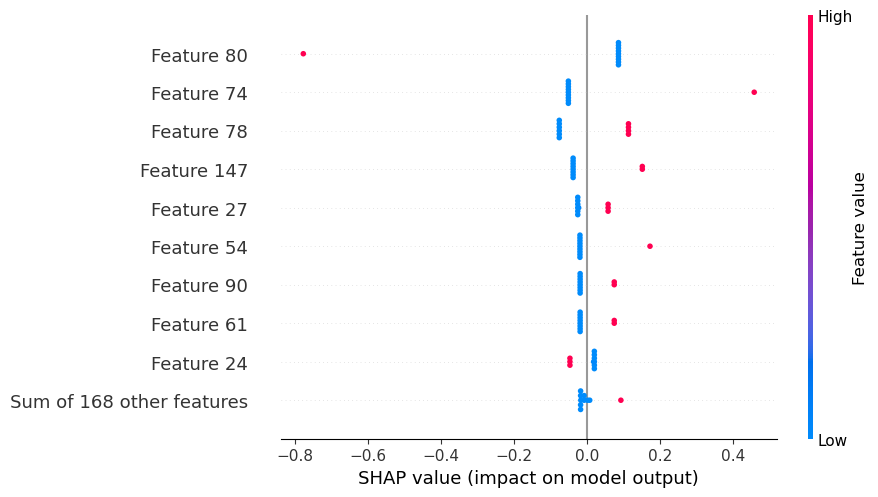

91 (10, 177, 91)


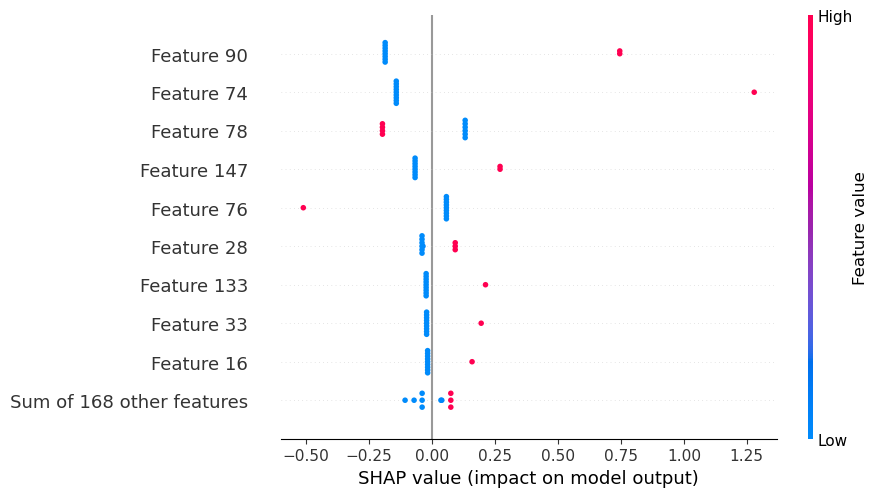

91 (10, 177, 91)


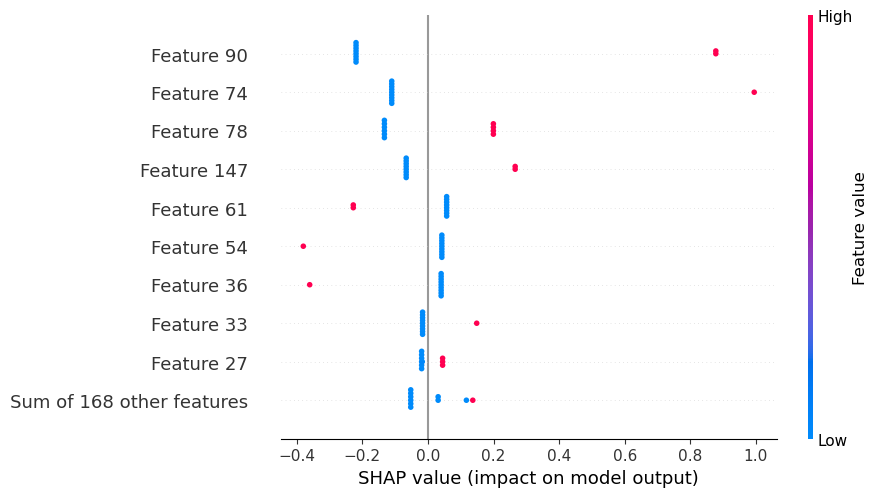

91 (10, 177, 91)


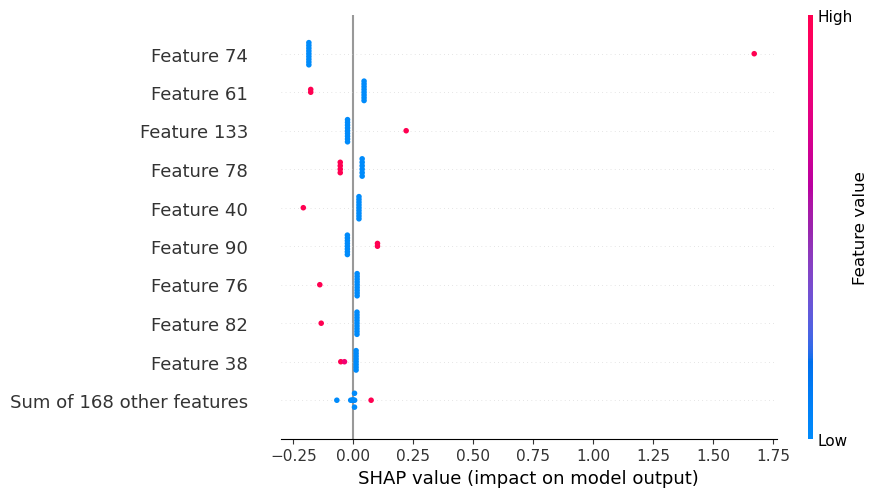

91 (10, 177, 91)


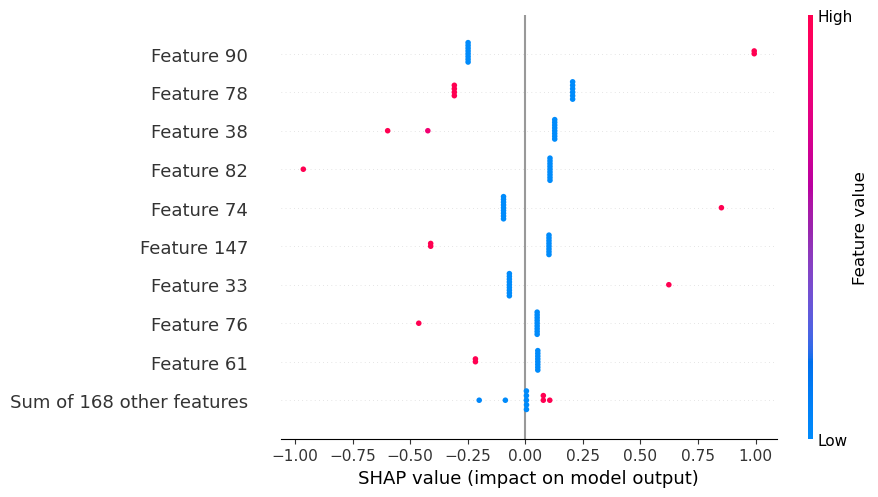

91 (10, 177, 91)


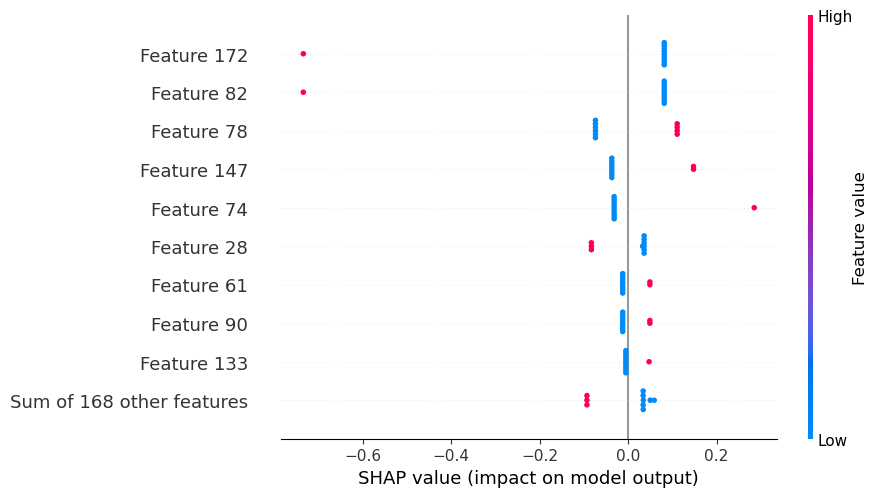

91 (10, 177, 91)


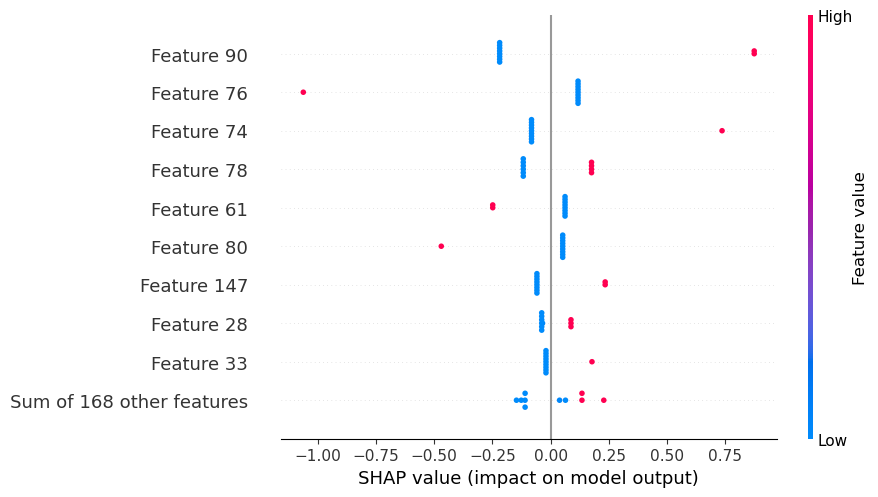

91 (10, 177, 91)


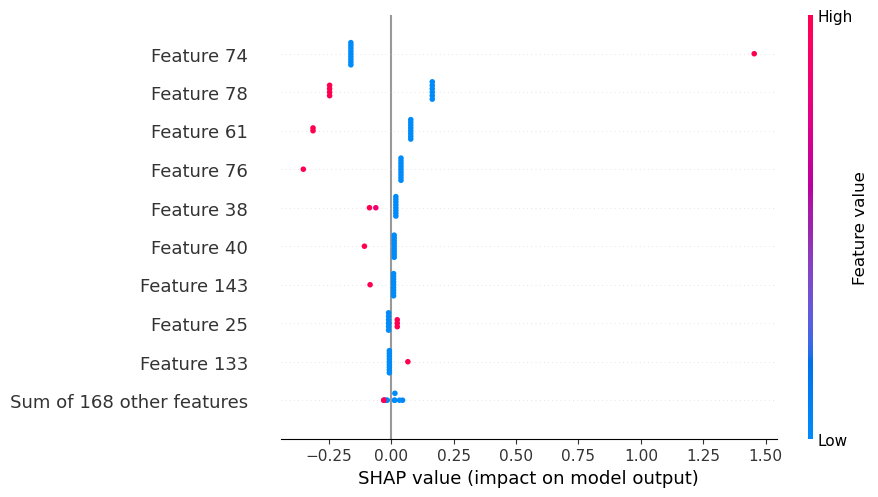

91 (10, 177, 91)


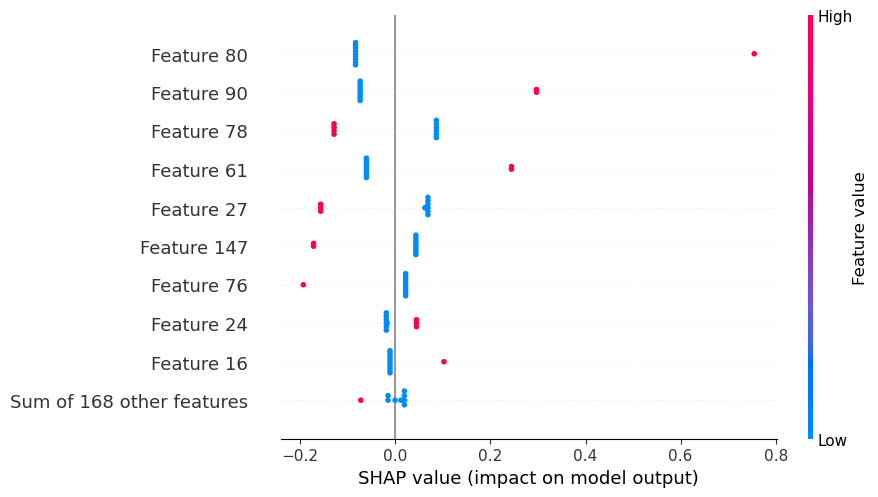

91 (10, 177, 91)


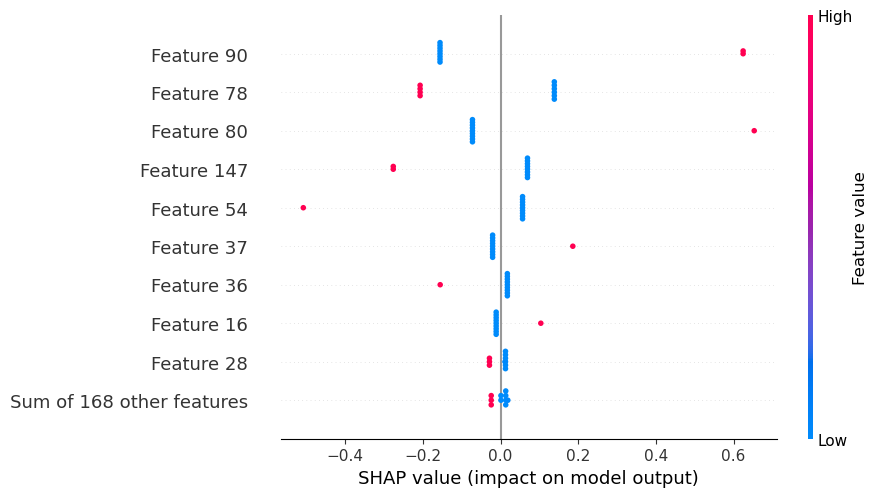

91 (10, 177, 91)


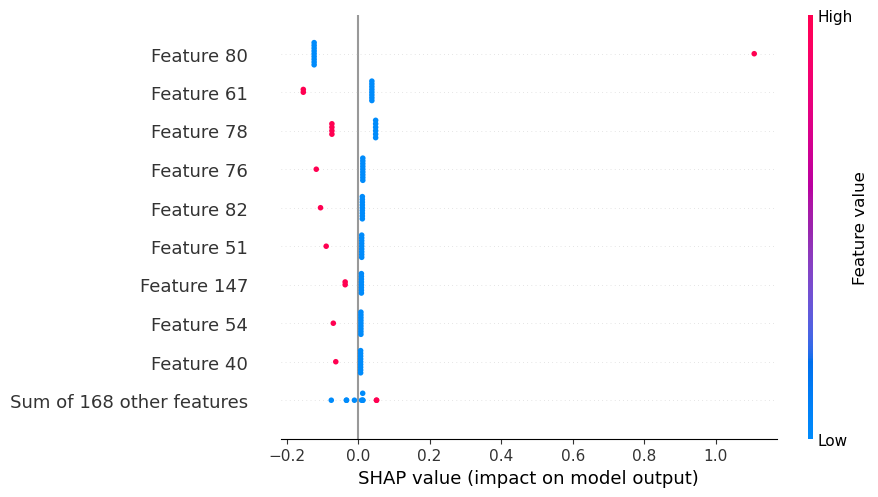

91 (10, 177, 91)


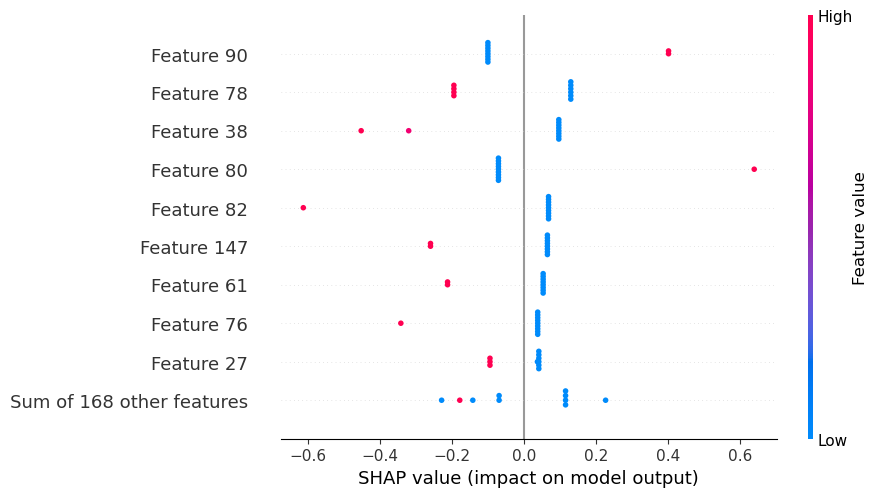

91 (10, 177, 91)


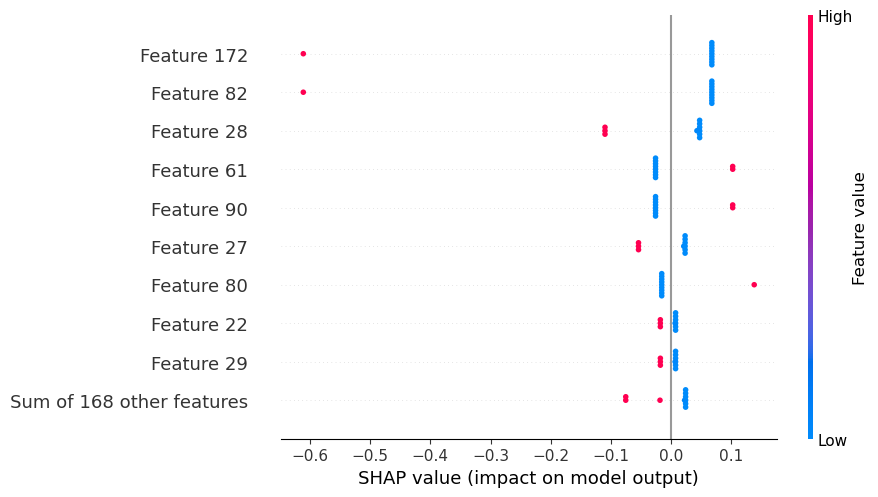

91 (10, 177, 91)


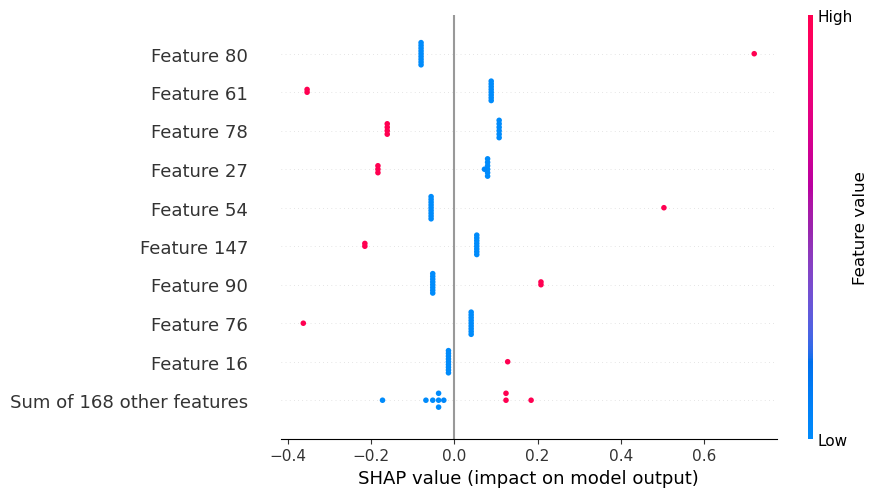

91 (10, 177, 91)


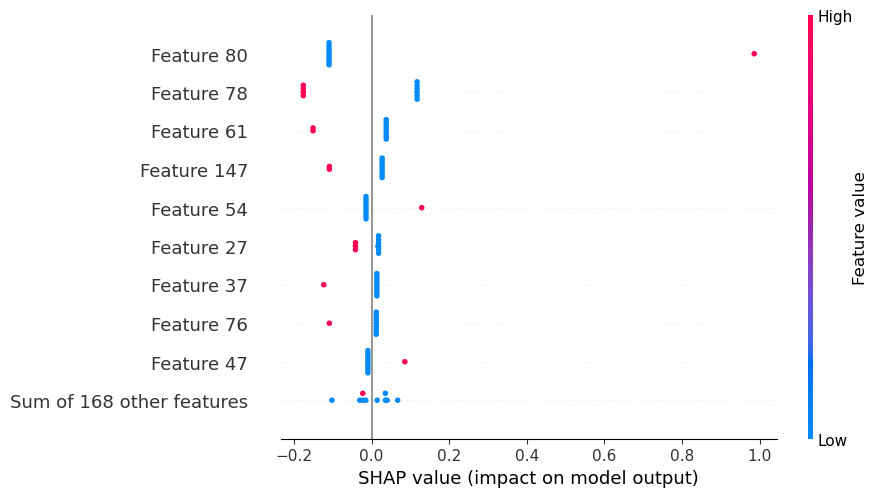

91 (10, 177, 91)


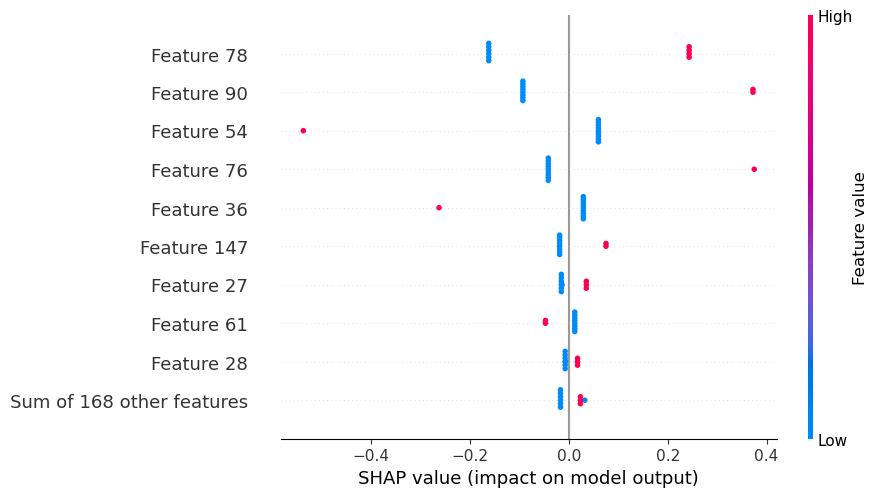

91 (10, 177, 91)


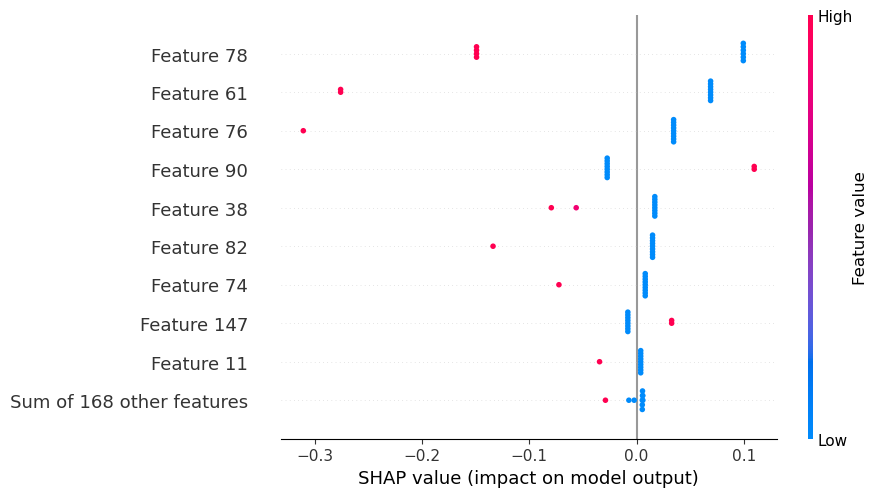

91 (10, 177, 91)


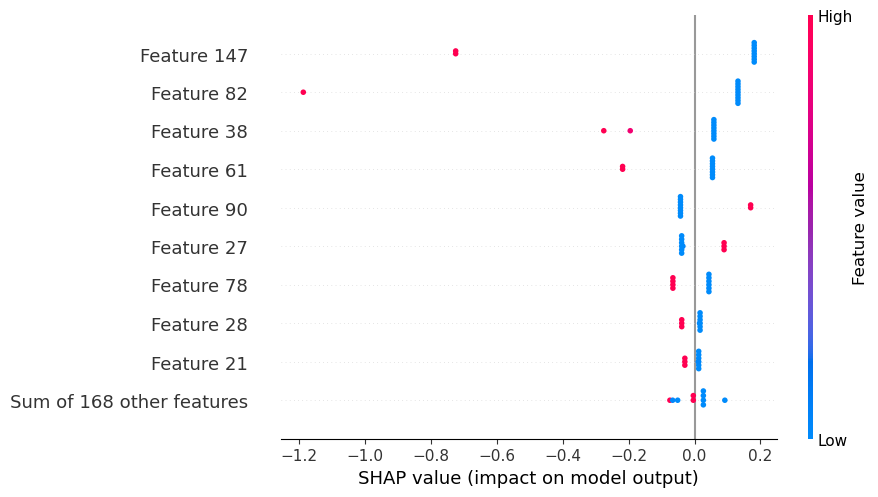

91 (10, 177, 91)


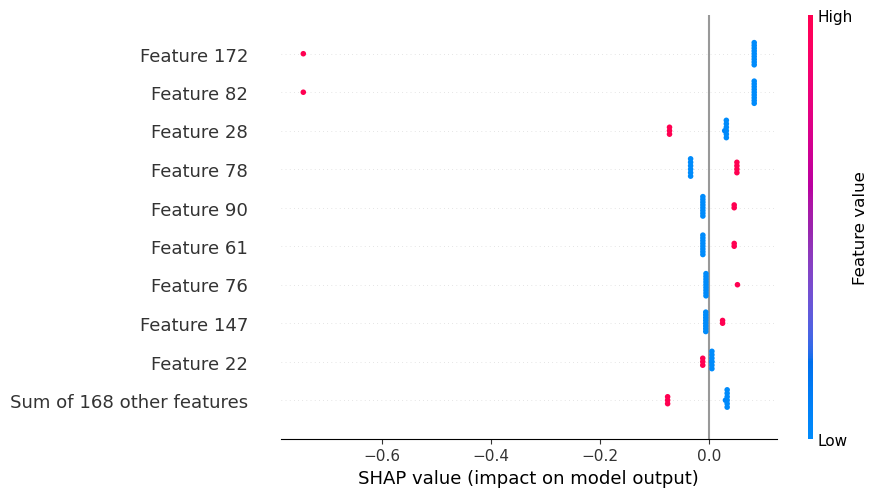

91 (10, 177, 91)


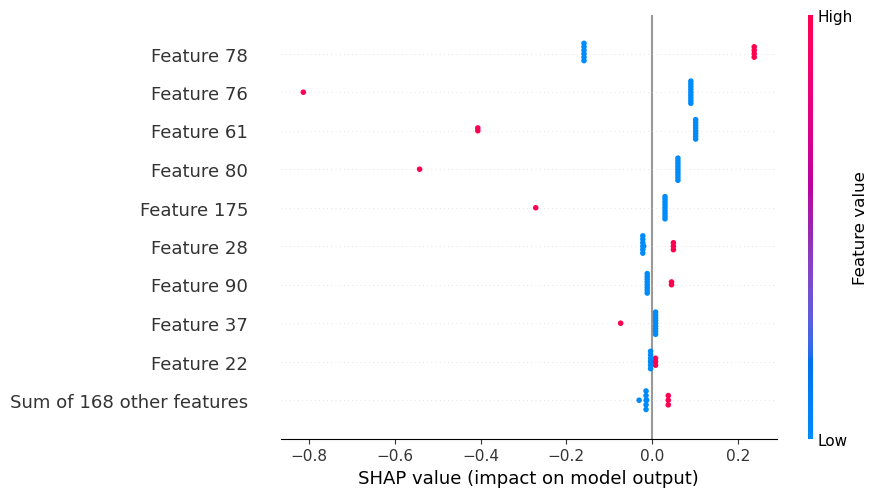

91 (10, 177, 91)


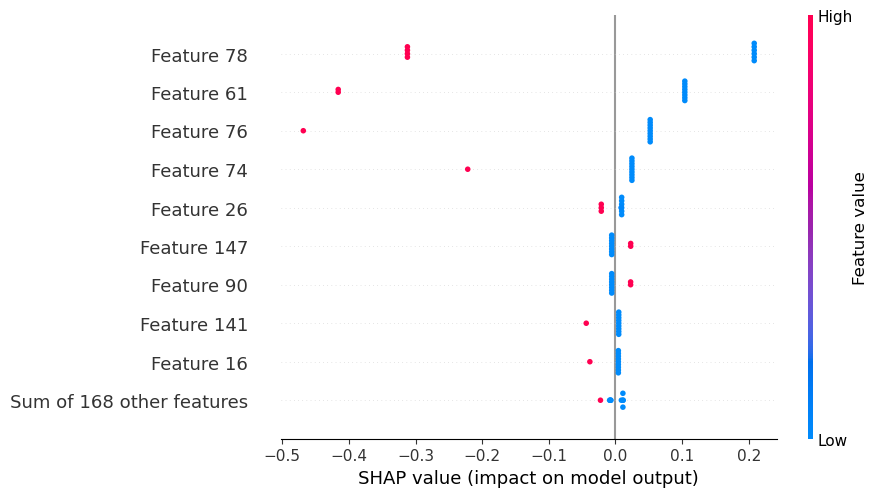

91 (10, 177, 91)


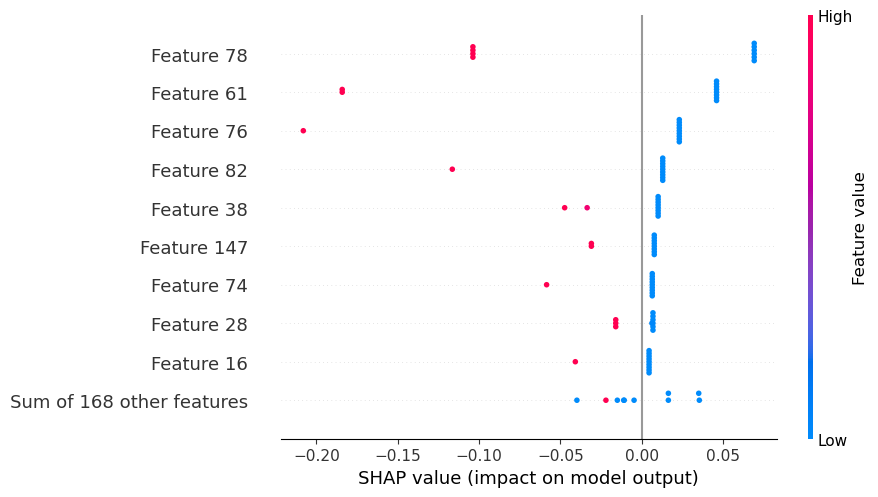

91 (10, 177, 91)


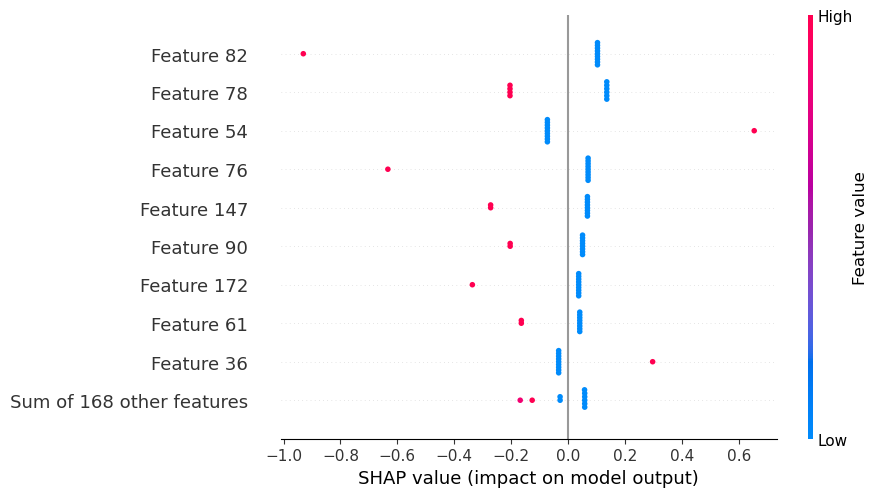

91 (10, 177, 91)


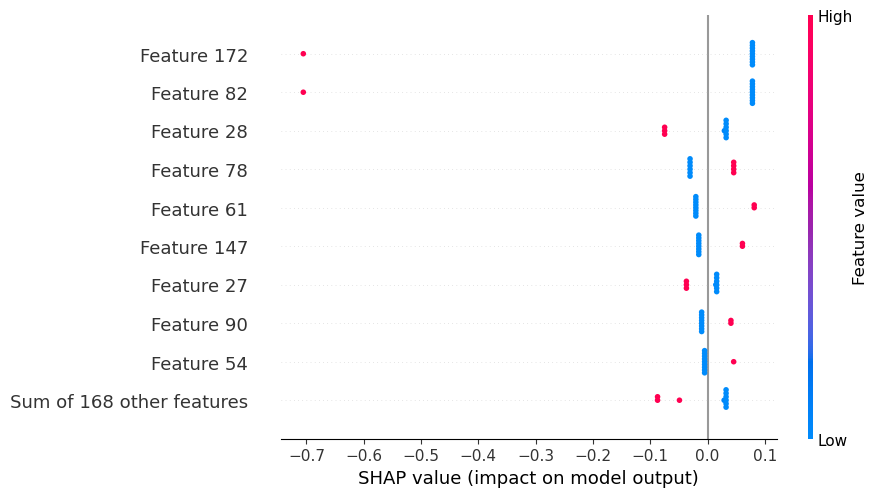

91 (10, 177, 91)


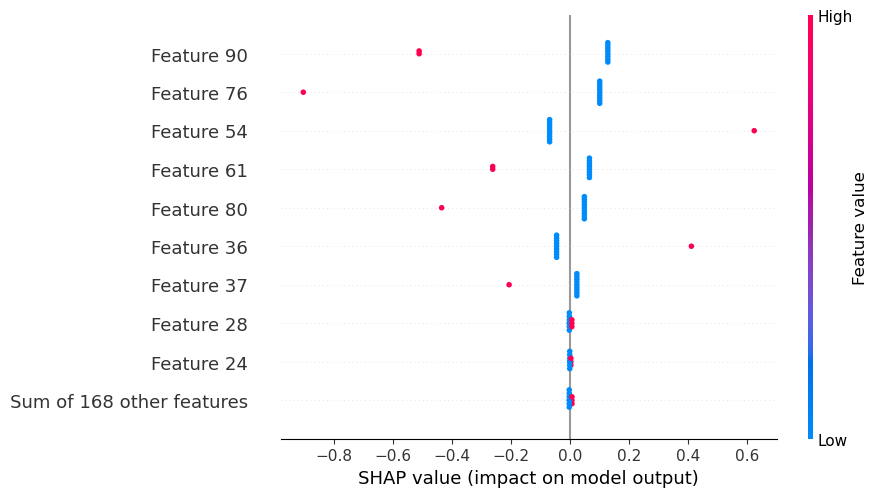

91 (10, 177, 91)


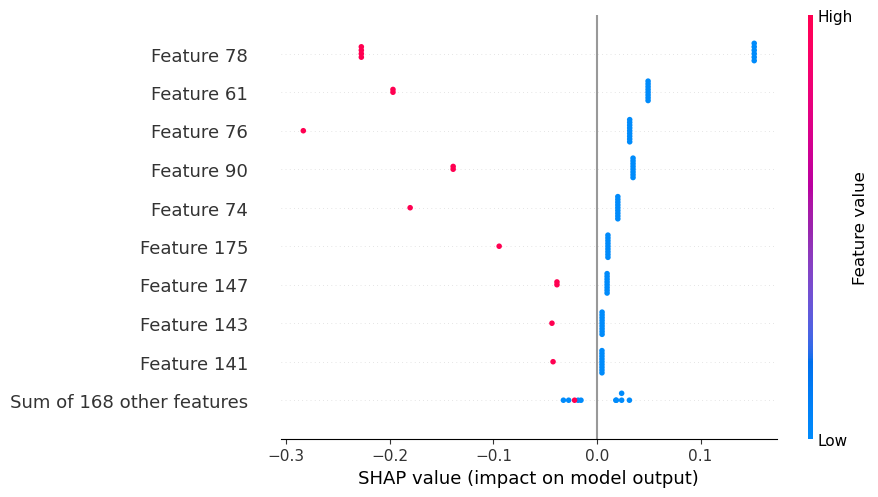

91 (10, 177, 91)


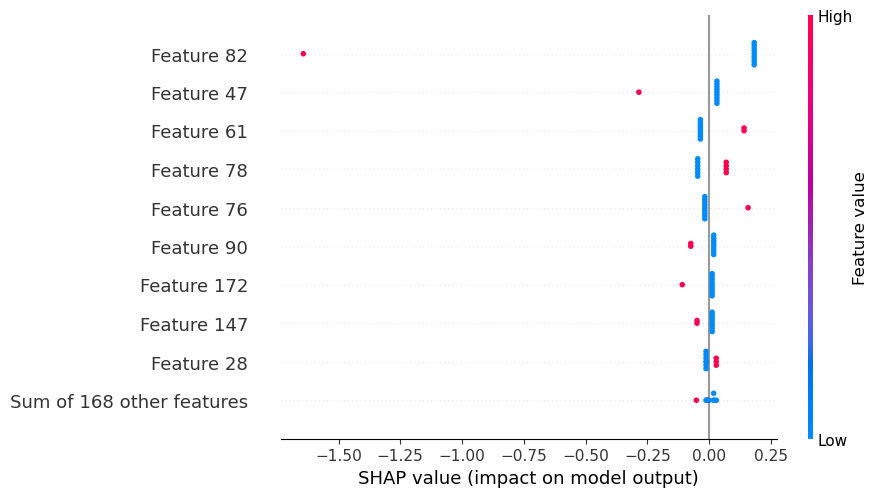

91 (10, 177, 91)


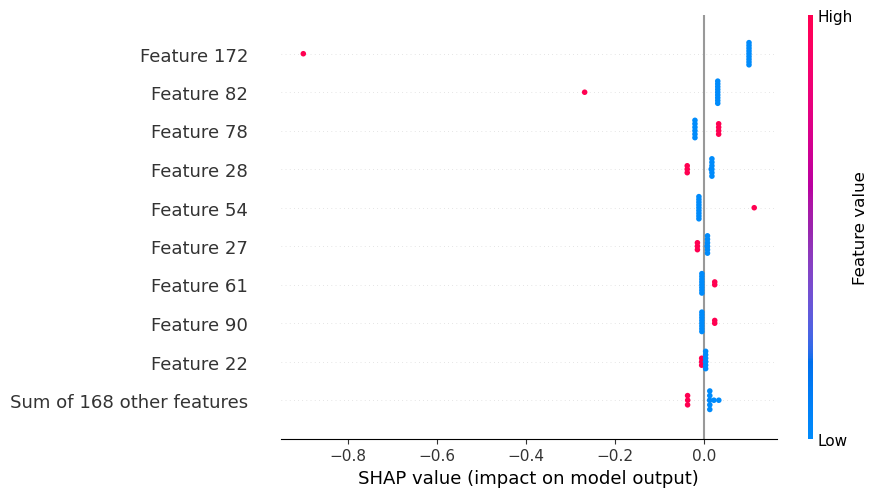

91 (10, 177, 91)


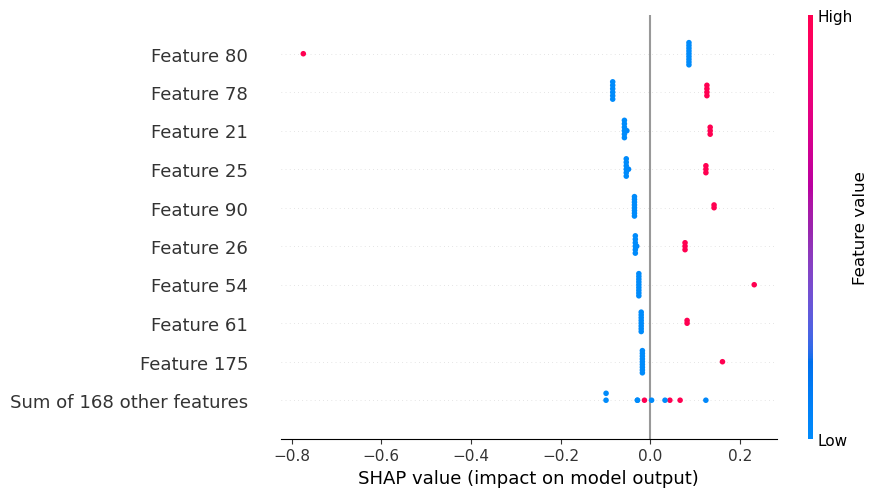

91 (10, 177, 91)


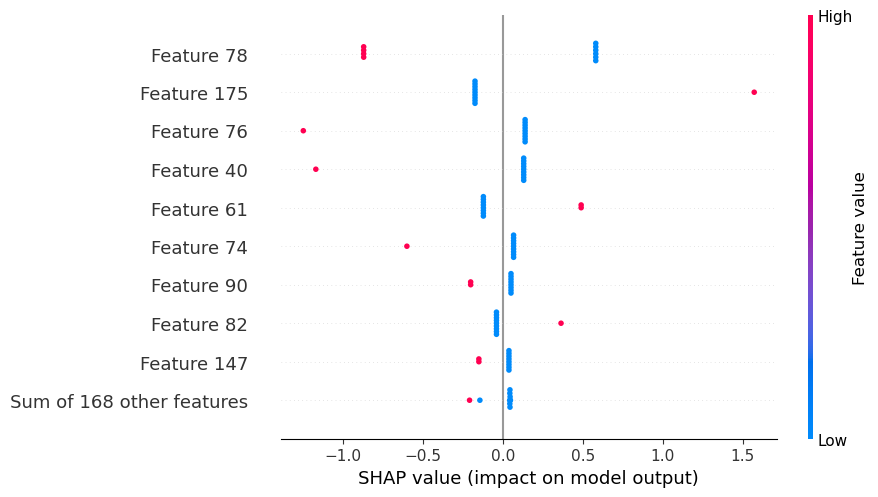

91 (10, 177, 91)


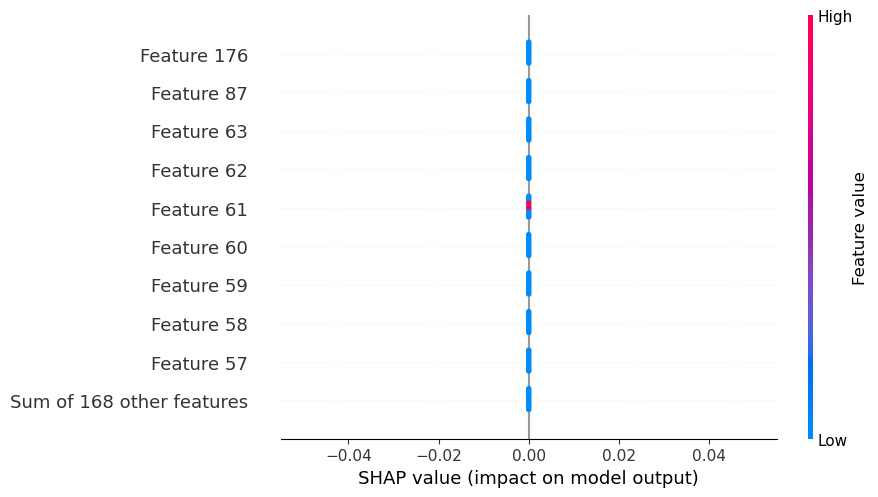

91 (10, 177, 91)


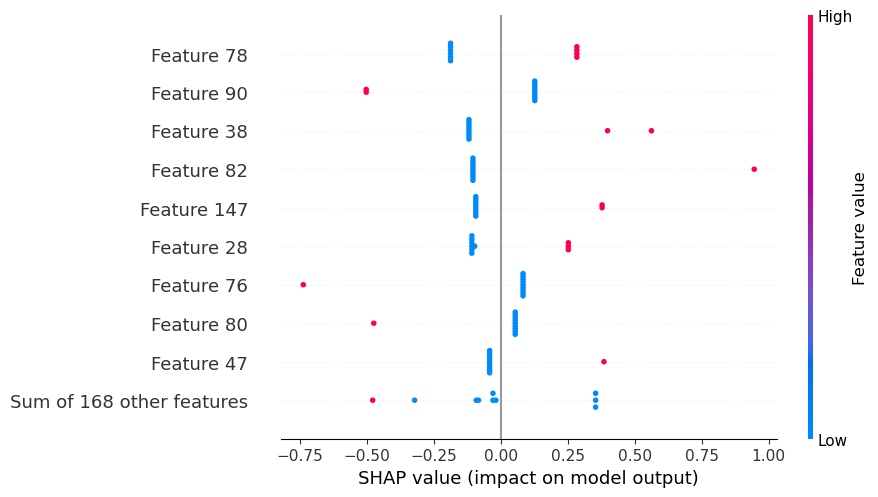

91 (10, 177, 91)


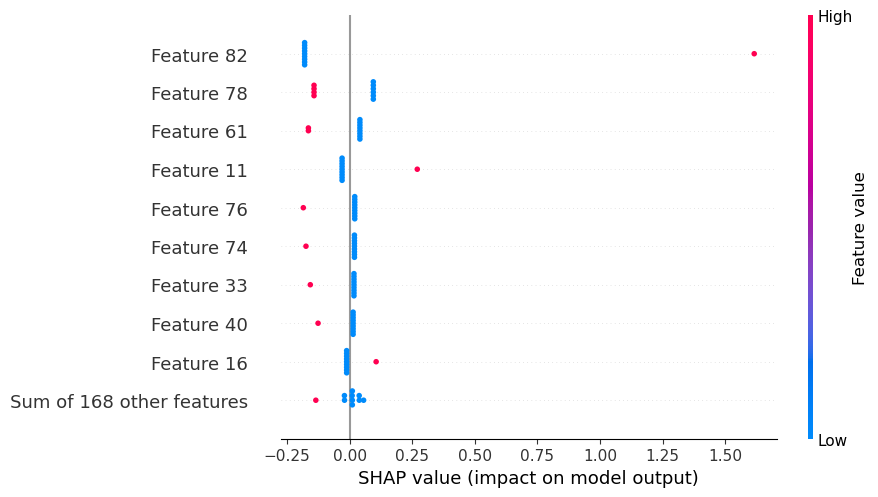

91 (10, 177, 91)


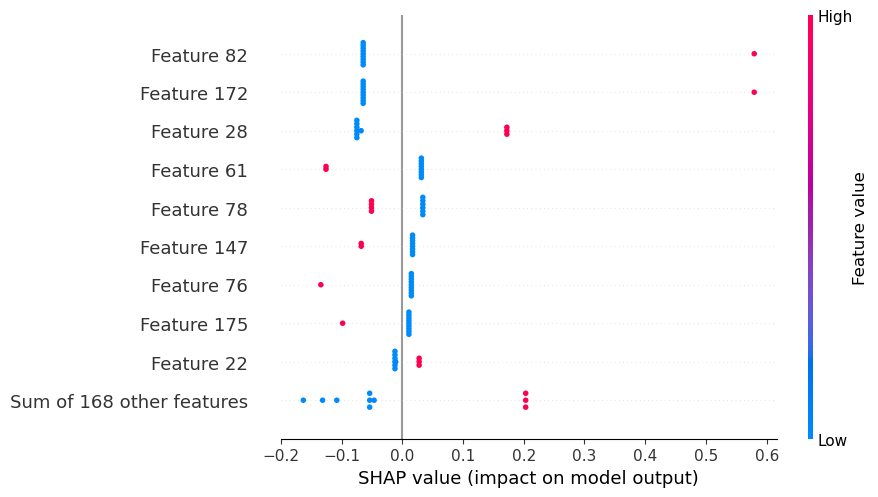

91 (10, 177, 91)


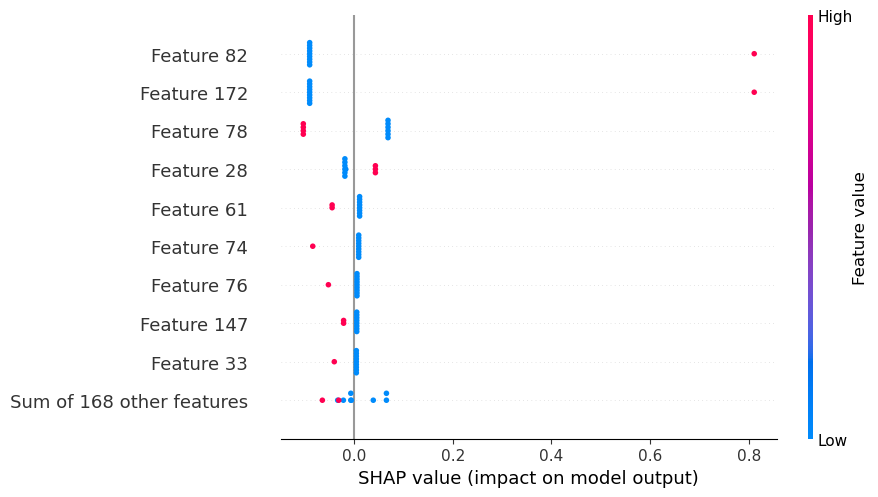

91 (10, 177, 91)


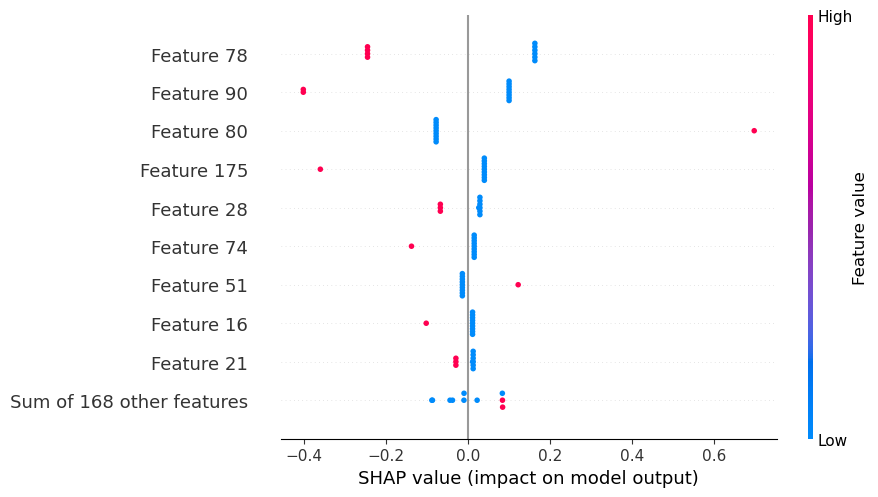

Metrics for MultinomialNB
Accuracy: 0.8926499032882012
Precision: 0.9153021496968824
Recall: 0.8926499032882012
F1-Score: 0.8921876850287928


100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


<Figure size 640x480 with 0 Axes>

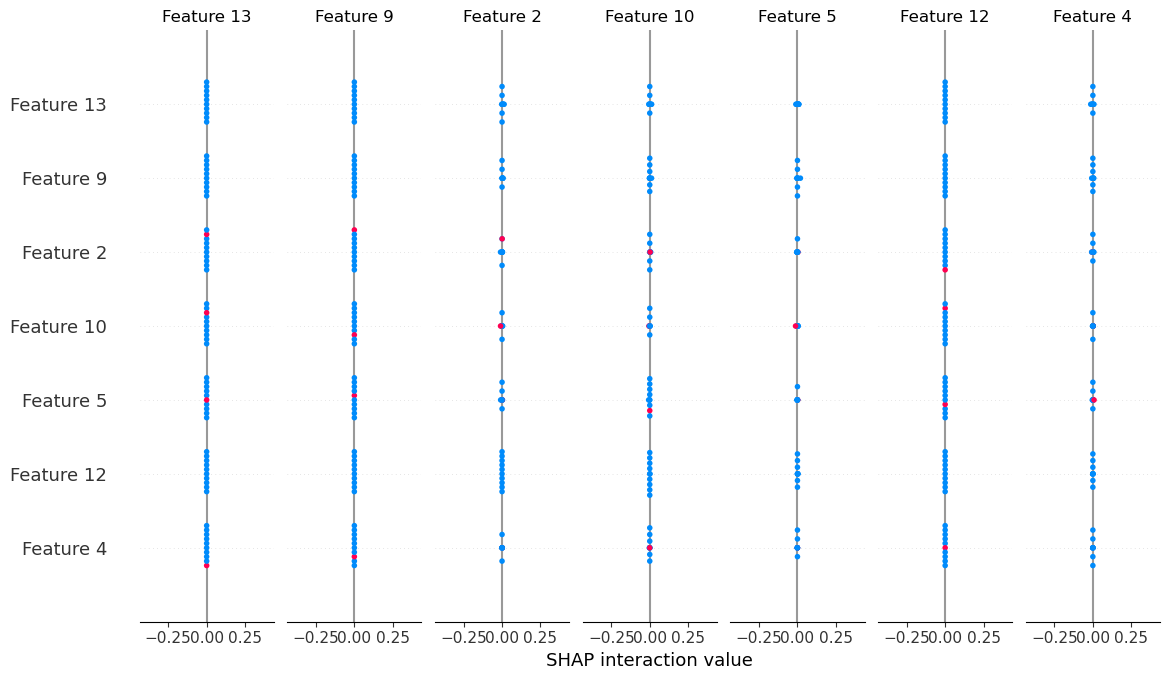

14 (10, 177, 14)


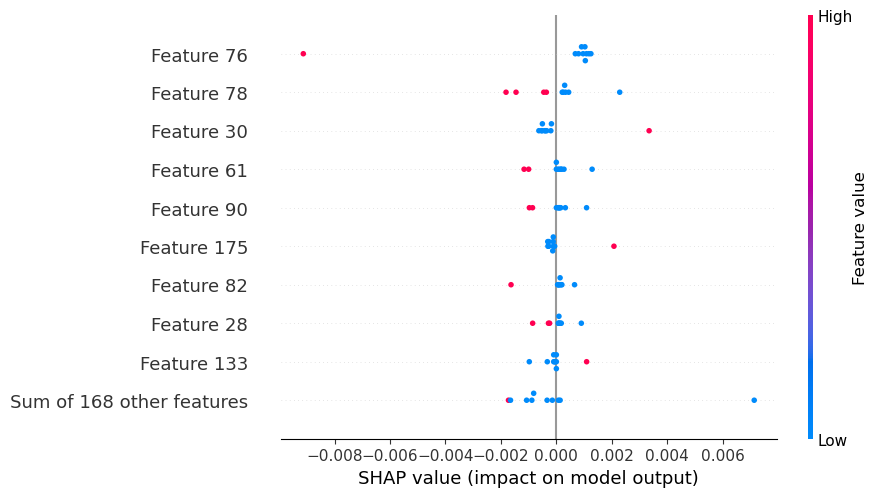

14 (10, 177, 14)


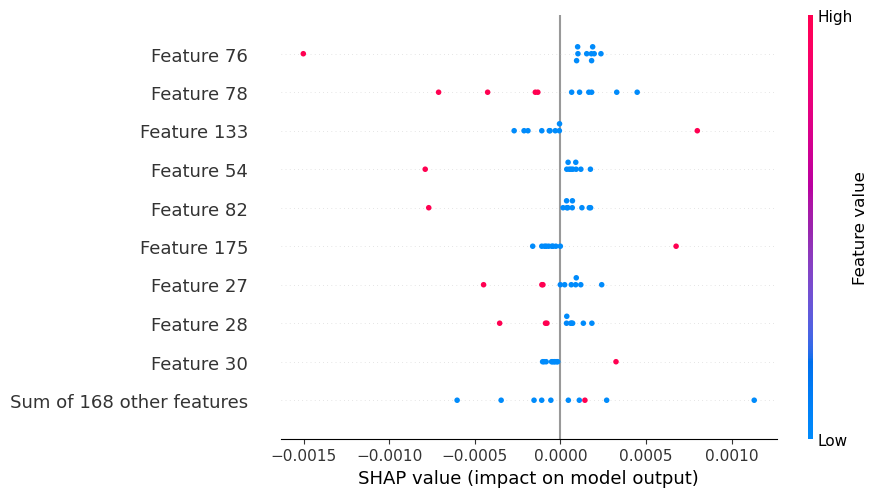

14 (10, 177, 14)


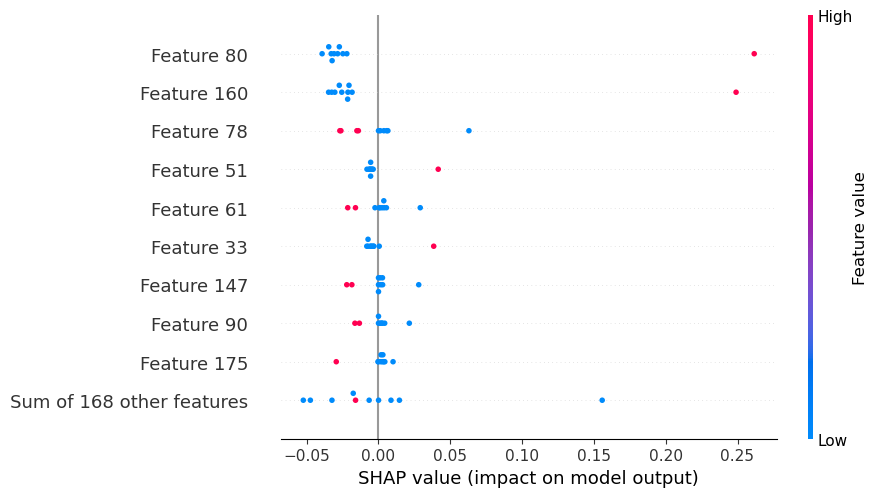

14 (10, 177, 14)


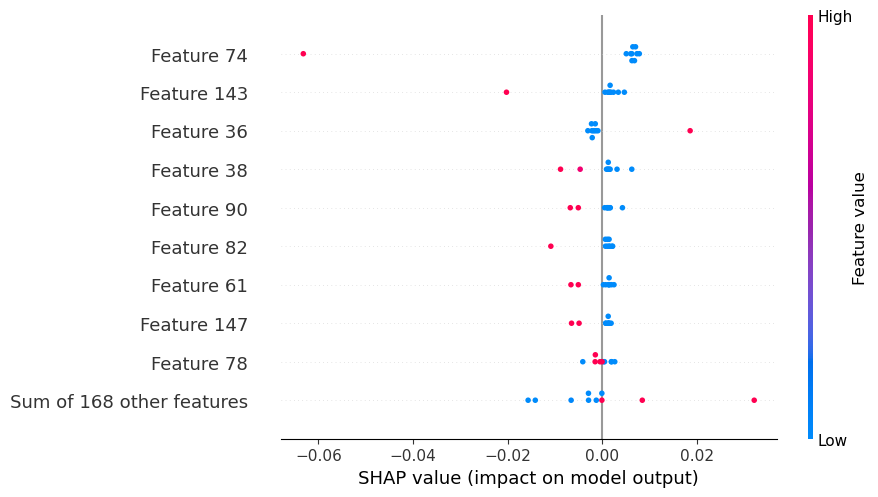

14 (10, 177, 14)


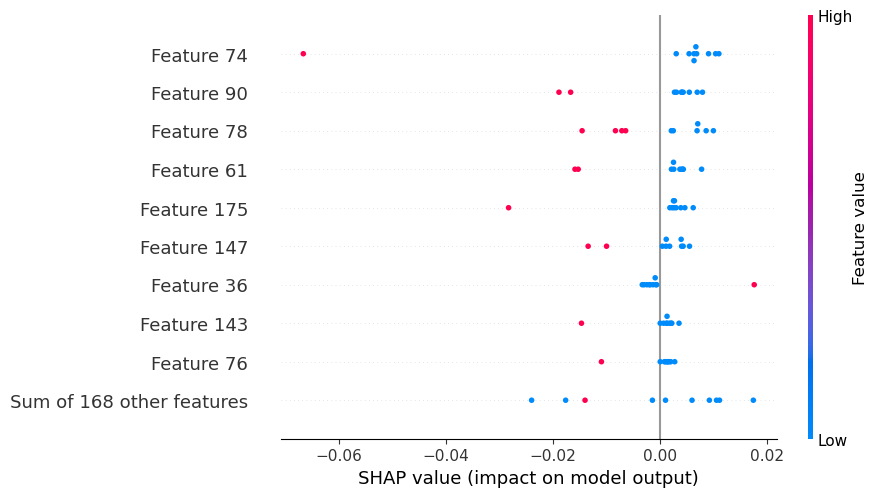

14 (10, 177, 14)


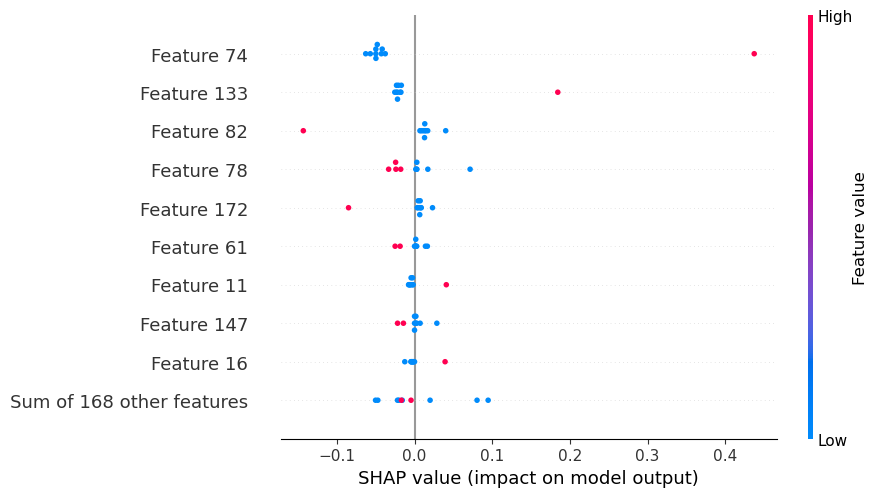

14 (10, 177, 14)


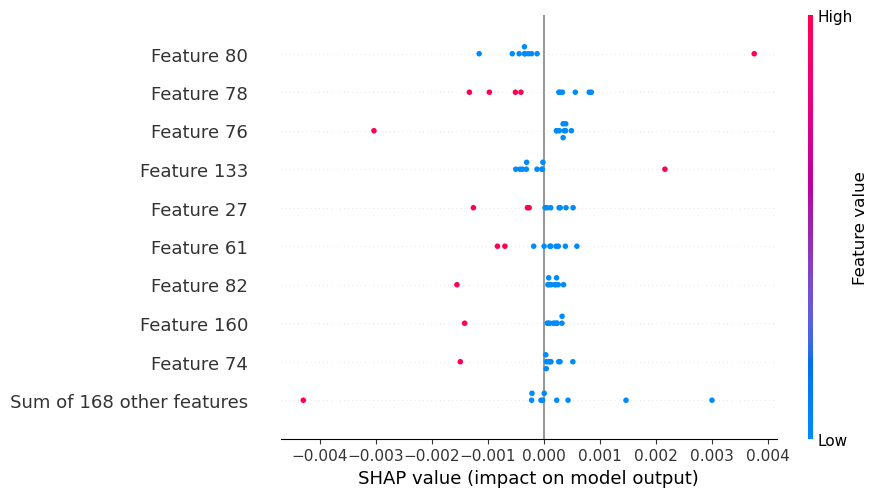

14 (10, 177, 14)


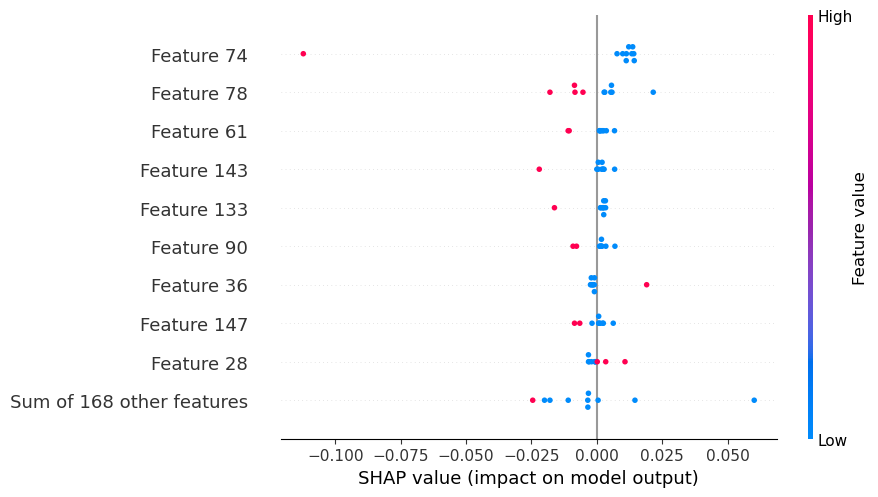

14 (10, 177, 14)


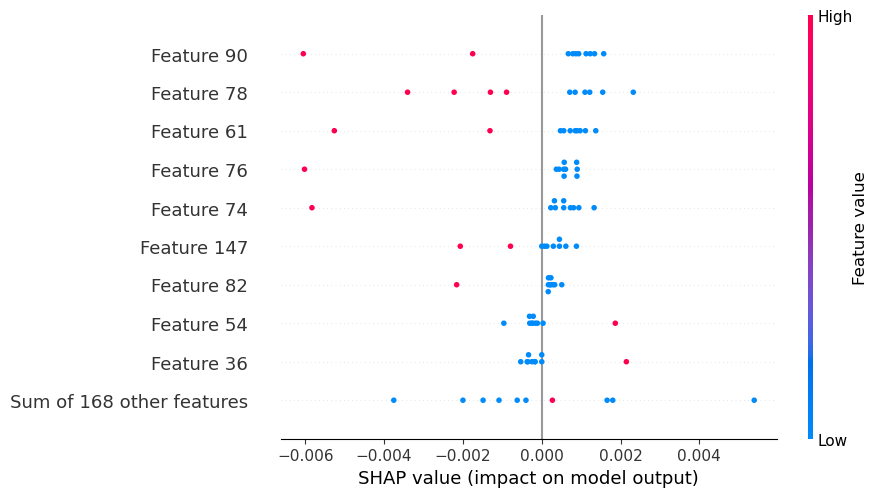

14 (10, 177, 14)


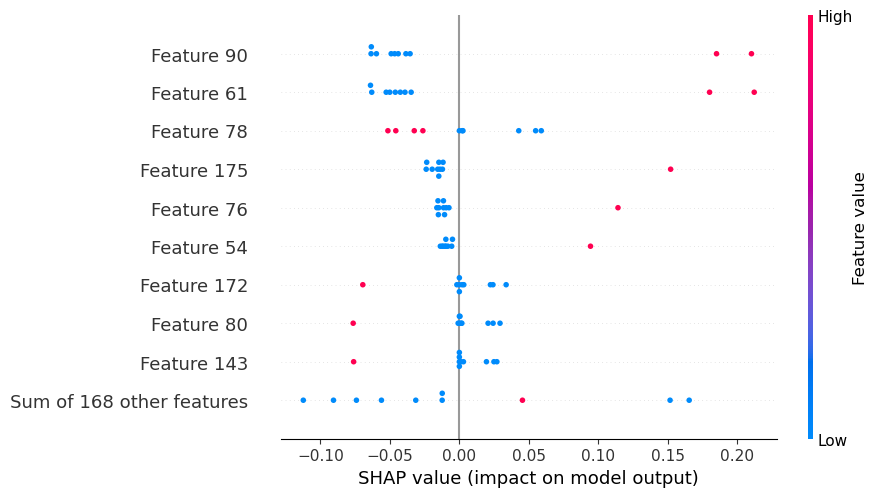

14 (10, 177, 14)


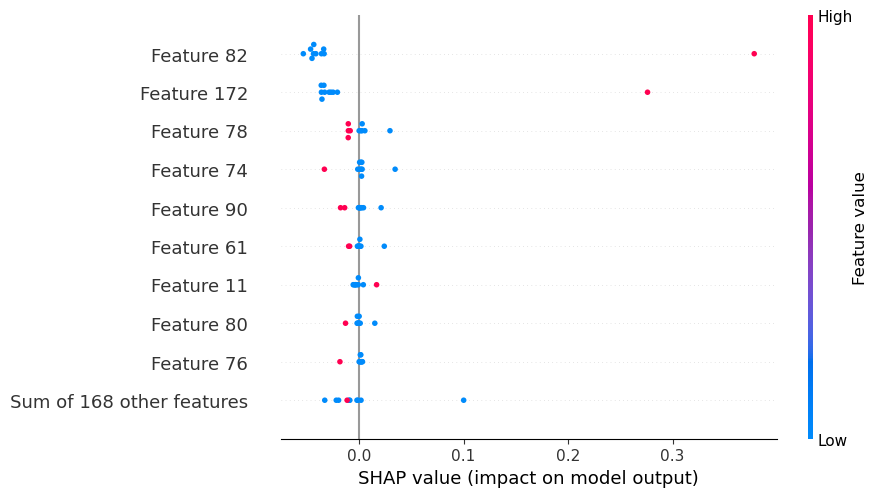

14 (10, 177, 14)


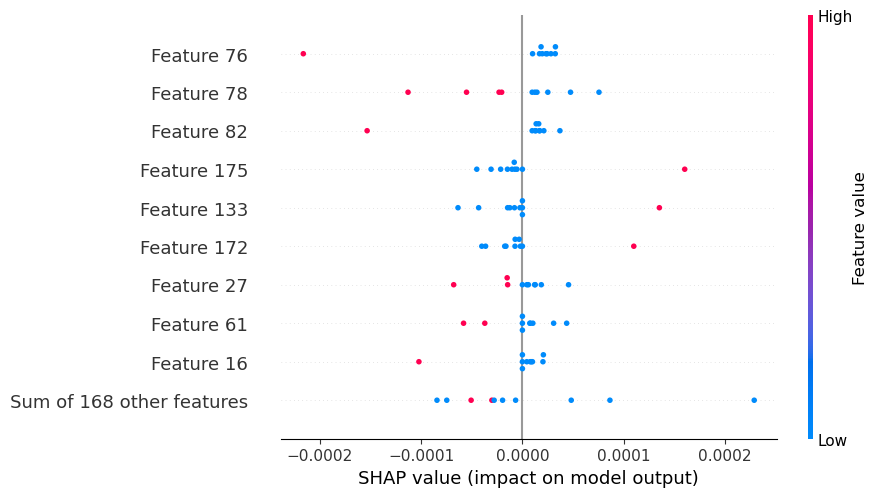

14 (10, 177, 14)


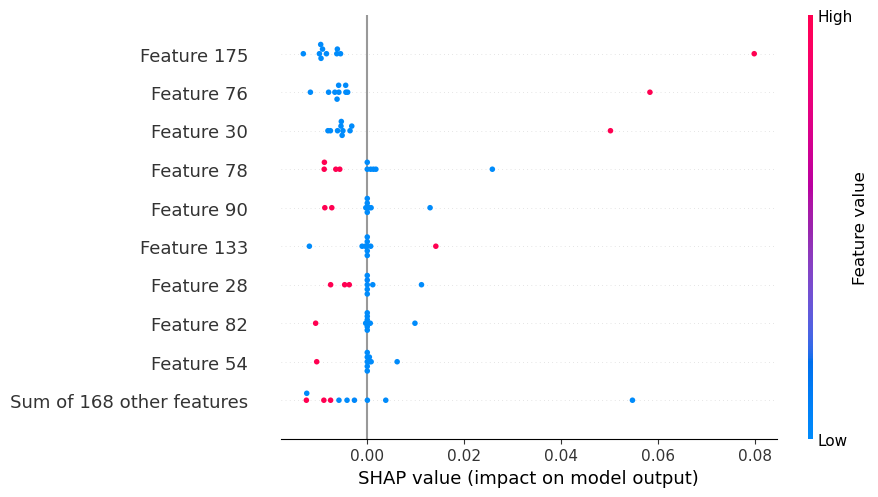

14 (10, 177, 14)


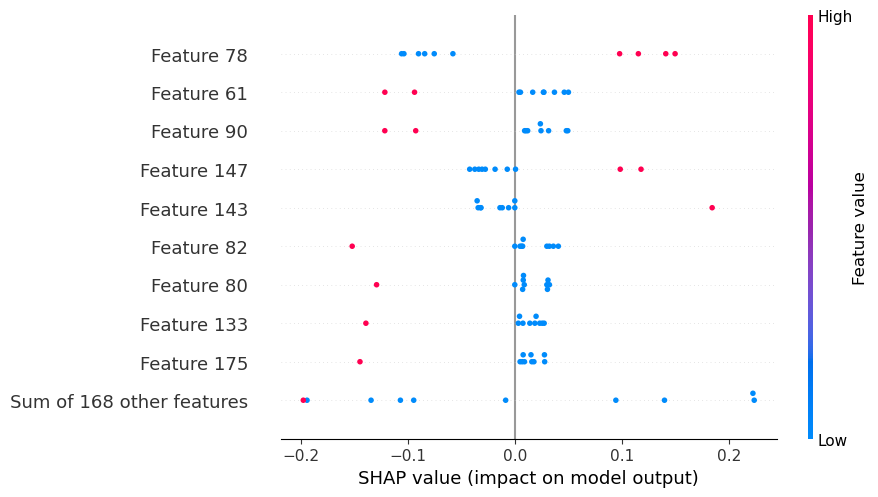

In [24]:
# Default GBI/GBL unmerged
y_col_key = 'Produkt Label (Merged)'

classification_description = 'merged_bike'

x_train, x_test, y_train, y_test = get_single_label_data(tickets, categorical_columns, y_col_key, 0.2)
shap_test = x_test[0:10]

print('Number training samples:', len(y_train))
print('Number test samples:', len(y_test))

# RandomForest classifier
rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 1)
classify_with_metrics(rf_classifier, x_train, y_train, x_test, y_test, classification_description)
shap_feature_analysis(rf_classifier, shap_test, classification_description)

# SVM classifier
svm_classifier = SVC(kernel = 'linear', random_state = 1) # tried all, linear is best
classify_with_metrics(svm_classifier, x_train, y_train, x_test, y_test, classification_description)
shap_feature_analysis(svm_classifier, shap_test, classification_description)

# Naive Bayes classifier
nb_classifier = MultinomialNB()
classify_with_metrics(nb_classifier, x_train, y_train, x_test, y_test, classification_description)
shap_feature_analysis(nb_classifier, shap_test, classification_description)

# LogReg 'max_iter' was increased from its default value because it threw a an erro in later execution 
# for not converging when kept at 100
# Logistic Regression classifier
# logreg_classifier = LogisticRegression(random_state = 1, max_iter = 200)
# classify_with_metrics(logreg_classifier, x_train, y_train, x_test, y_test, classification_description)

# # KNN classifier
# knn_classifier = KNeighborsClassifier(n_neighbors = 5)
# classify_with_metrics(knn_classifier, x_train, y_train, x_test, y_test, classification_description)

# LSW: I want to see a Perceptron Approach
# sgd_classifier = SGDClassifier(loss="perceptron", learning_rate="constant", eta0=0.02)
# classify_with_metrics(sgd_classifier, x_train, y_train, x_test, y_test, classification_description)

In [25]:
# # Bike Internal Classification
# y_col_key = 'Produkt Label'

# bike_tickets = tickets[tickets['Produkt Label (Merged)'] == 'global bike']

# classification_description = 'bike_internal_accurate'

# # print('Number training samples:', len(y_train))
# # print('Number test samples:', len(y_test))

# # RandomForest classifier
# x_train, x_test, y_train, y_test = get_single_label_data(bike_tickets[bike_tickets['RandomForestClassifier Predictions'] == 'global bike'], categorical_columns, y_col_key, 0.2)
# rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 1)
# classify_with_metrics(rf_classifier, x_train, y_train, x_test, y_test, classification_description)

# # SVM classifier
# x_train, x_test, y_train, y_test = get_single_label_data(bike_tickets[bike_tickets['SVC Predictions'] == 'global bike'], categorical_columns, y_col_key, 0.2)
# svm_classifier = SVC(kernel = 'linear', random_state = 1)
# classify_with_metrics(svm_classifier, x_train, y_train, x_test, y_test, classification_description)

# # Naive Bayes classifier
# x_train, x_test, y_train, y_test = get_single_label_data(bike_tickets[bike_tickets['MultinomialNB Predictions'] == 'global bike'], categorical_columns, y_col_key, 0.2)
# nb_classifier = MultinomialNB()
# classify_with_metrics(nb_classifier, x_train, y_train, x_test, y_test, classification_description)

# # LogReg 'max_iter' was increased from its default value because it threw a an erro in later execution 
# # for not converging when kept at 100
# # Logistic Regression classifier
# x_train, x_test, y_train, y_test = get_single_label_data(bike_tickets[bike_tickets['LogisticRegression Predictions'] == 'global bike'], categorical_columns, y_col_key, 0.2)
# logreg_classifier = LogisticRegression(random_state = 1, max_iter = 200)
# classify_with_metrics(logreg_classifier, x_train, y_train, x_test, y_test, classification_description)

# # KNN classifier
# x_train, x_test, y_train, y_test = get_single_label_data(bike_tickets[bike_tickets['KNeighborsClassifier Predictions'] == 'global bike'], categorical_columns, y_col_key, 0.2)
# knn_classifier = KNeighborsClassifier(n_neighbors = 5)
# classify_with_metrics(knn_classifier, x_train, y_train, x_test, y_test, classification_description)

# # # LSW: I want to see a Perceptron Approach
# # sgd_classifier = SGDClassifier(loss="perceptron", learning_rate="constant", eta0=0.02)
# # classify_with_metrics(sgd_classifier, x_train, y_train, x_test, y_test, classification_description)

In [26]:
# from sklearn.preprocessing import LabelEncoder
# from statsmodels.stats.inter_rater import fleiss_kappa

# single_incorrect_tickets = tickets[tickets['error_count'] > 0]

# pred_columns = ['RandomForestClassifier Predictions', 'SVC Predictions', 'MultinomialNB Predictions',
#                 'LogisticRegression Predictions', 'KNeighborsClassifier Predictions']

# # Extract the relevant prediction columns
# predictions_df = single_incorrect_tickets[pred_columns].copy()

# # Initialize label encoders for each column and encode the predictions into numerical form
# label_encoders = {}
# for col in pred_columns:
#     le = LabelEncoder()
#     predictions_df[col] = le.fit_transform(predictions_df[col])
#     label_encoders[col] = le  # Store label encoders if needed later for decoding

# # Get the number of unique categories (classes) in the predictions
# categories = len(np.unique(predictions_df.values))

# # Build a matrix where each row contains the vote counts for each category
# # This is required for Fleiss' Kappa calculation
# kappa_matrix = []
# for row in predictions_df.values:
#     vote_counts = [list(row).count(c) for c in range(categories)]
#     kappa_matrix.append(vote_counts)

# # Convert the matrix into a DataFrame
# kappa_matrix_df = pd.DataFrame(kappa_matrix)

# # Compute Fleiss' Kappa using the transformed data
# kappa_value = fleiss_kappa(kappa_matrix_df)

# # Output the result
# print(f"Fleiss' Kappa: {kappa_value}")

In [27]:
# # Incorrectly Labelled Data only with GBI/GBL merged
# single_incorrect_tickets = tickets[tickets['error_count'] > 0]
# # single_incorrect_tickets = single_incorrect_tickets[['Text', 'Beschreibung', 'Kategorie ID', 'Unterkategorie ID', 'stemmed_text', 'stemmed_beschreibung', 'Produkt Label (Merged)', 'New Labels']]
# # single_incorrect_tickets.head()
# # single_incorrect_tickets.to_excel('~/Desktop/error_tickets.xlsx')

# y_col_key = 'Produkt Label (Merged)'

# x_train, x_test, y_train, y_test = get_single_label_data(single_incorrect_tickets, categorical_columns, y_col_key, 0.2)

# classification_description = 'merged_bike_incorrect_labels_only'

# print('Number training samples:', len(y_train))
# print('Number test samples:', len(y_test))

# # RandomForest classifier
# rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 1)
# classify_with_metrics(rf_classifier, x_train, y_train, x_test, y_test, classification_description)

# # SVM classifier
# svm_classifier = SVC(kernel = 'linear', random_state = 1)
# classify_with_metrics(svm_classifier, x_train, y_train, x_test, y_test, classification_description)

# # Naive Bayes classifier
# nb_classifier = MultinomialNB()
# classify_with_metrics(nb_classifier, x_train, y_train, x_test, y_test, classification_description)

# # LogReg 'max_iter' was increased from its default value because it threw a an erro in later execution 
# # for not converging when kept at 100
# # Logistic Regression classifier
# logreg_classifier = LogisticRegression(random_state = 1, max_iter = 200)
# classify_with_metrics(logreg_classifier, x_train, y_train, x_test, y_test, classification_description)

# # KNN classifier
# knn_classifier = KNeighborsClassifier(n_neighbors = 5)
# classify_with_metrics(knn_classifier, x_train, y_train, x_test, y_test, classification_description)

# # LSW: I want to see a Perceptron Approach
# sgd_classifier = SGDClassifier(loss="perceptron", learning_rate="constant", eta0=0.02)
# classify_with_metrics(sgd_classifier, x_train, y_train, x_test, y_test, classification_description)

In [28]:
# labels = tickets['New Labels'].map(lambda labels_str: labels_str.split(','))

# # classes = list(set(tickets['Produkt Label (Merged)']))
# multi_binarizer = MultiLabelBinarizer()
# multi_binarizer.fit(labels)

# def get_multi_label_data(test_size = 0.2):
#     x_train_raw, x_test_raw, y_train, y_test = train_test_split(
#         tickets[['stemmed_text', 'stemmed_beschreibung'] + categorical_columns], # x
#         labels, # y
#         test_size = test_size,
#         random_state = 1)

#     y_train = multi_binarizer.transform(y_train)
#     y_test = multi_binarizer.transform(y_test)

#     # Tfidf vectorization for the training set
#     # TEXT column
#     tfidf_vectorizer_text = TfidfVectorizer(max_features = 30)
#     tfidf_matrix_text_train = tfidf_vectorizer_text.fit_transform(x_train_raw['stemmed_text'].values.astype('U'))
#     # DESCRIPTION column
#     tfidf_vectorizer_description = TfidfVectorizer(max_features = 30)
#     tfidf_matrix_description_train = tfidf_vectorizer_description.fit_transform(x_train_raw['stemmed_beschreibung'].values.astype('U'))
#     # Combine the Tfidf train-matrices horizontally
#     tfidf_matrix_combined_train = hstack((tfidf_matrix_text_train, tfidf_matrix_description_train))

#     # Tfidf vectorization for the testing set
#     # TEXT and DECRIPTION column
#     tfidf_matrix_text_test = tfidf_vectorizer_text.transform(x_test_raw['stemmed_text'].values.astype('U'))
#     tfidf_matrix_description_test = tfidf_vectorizer_description.transform(x_test_raw['stemmed_beschreibung'].values.astype('U'))
#     # Combine the Tfidf test-matrices horizontally
#     tfidf_matrix_combined_test = hstack((tfidf_matrix_text_test, tfidf_matrix_description_test))

#     # 6b. Combining categorical and text data
#     # One-hot encoding for categorical data
#     encoder = OneHotEncoder(handle_unknown = 'ignore')
#     encoded_data_train = encoder.fit_transform(x_train_raw[categorical_columns]).toarray()
#     encoded_data_test = encoder.transform(x_test_raw[categorical_columns]).toarray()

#     # Convert the one-hot encoded arrays to sparse matrices
#     encoded_sparse_train = scipy.sparse.csr_matrix(encoded_data_train)
#     encoded_sparse_test = scipy.sparse.csr_matrix(encoded_data_test)

#     # Combine TF-IDF matrix and one hot encoded matrix horizontally for both training and testing sets
#     x_train = hstack((tfidf_matrix_combined_train, encoded_sparse_train))
#     x_test = hstack((tfidf_matrix_combined_test, encoded_sparse_test))

#     return x_train, x_test, y_train, y_test

# #print(final_matrix_train)

# # Classification and evaluation in one method with different classifiers as parameter
# def multiclassify_with_metrics(classifier, x_train, y_train, x_test, y_test):
#     clf_name = 'Multi Label ' + classifier.__class__.__name__

#     # Initializing and prediction
#     multi_clf = MultiOutputClassifier(classifier).fit(x_train, y_train)
#     y_pred = multi_clf.predict(x_test)
    
#     # Performance evaluation
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average = 'weighted', zero_division=1)
#     recall = recall_score(y_test, y_pred, average= 'weighted')
#     f1_scr = f1_score(y_test, y_pred, average = 'weighted')
    
#     # str_pred = multi_binarizer.inverse_transform(y_pred)
#     # str_test = multi_binarizer.inverse_transform(y_test)
#     # print(str_pred)
#     # print(str_test)

#     conf_matrix = multilabel_confusion_matrix(y_test, y_pred)

#     # Worst missclassified labels
#     # upper_triangle = np.triu(conf_matrix, k = 1)
#     # worst_indices = np.unravel_index(np.argmax(upper_triangle), upper_triangle.shape)
#     # worst_one = worst_indices[0]
#     # worst_two = worst_indices[1]

#     # Evaluation metrics output
#     print(f'Metrics for {clf_name}')
#     print('ALL COMPARISONS FOR THE METRICS WERE BETWEEN SETS WHICH MUST CONTAIN IDENTICAL ELEMENTS')
#     print('Accuracy:', accuracy)
#     print('Precision:', precision)
#     print('Recall:', recall)
#     print('F1-Score:', f1_scr)
#     # print('Biggest error betwenen:', worst_one, 'and', worst_two)
    
#     # Confusion Matrix Display
#     fig, axes = plt.subplots(3, 5, figsize=(25, 15))
#     axes = axes.ravel()

#     for class_index in range(0, conf_matrix.shape[0]):
#         class_name = multi_binarizer.classes_[class_index]
#         class_conf_mat = conf_matrix[class_index]

#         cm_display = ConfusionMatrixDisplay(class_conf_mat, display_labels=['True', 'False'])
#         cm_display.plot(ax=axes[class_index], cmap = "Blues", values_format = "d", xticks_rotation = 'vertical')
#         cm_display.ax_.set_title(class_name)
#         plt.xlabel('Predicted Label')
#         plt.ylabel('True Label')
#         cm_display.im_.colorbar.remove()

#     plt.subplots_adjust(wspace=0.25, hspace=0.35)
#     # f.colorbar(disp.im_, ax=axes)
#     fig.delaxes(axes[14])
#     fig.suptitle(f'{clf_name} Confusion Matrices', fontsize=16, y=0.03)
#     plt.show()

#     fig.savefig(f"{clf_name}_confusion_matrix.jpg", format = 'jpg', dpi = 300, bbox_inches = 'tight')

#     print('/n')
    
# x_train, x_test, y_train, y_test = get_multi_label_data()

# # RandomForest classifier
# rf_classifier = RandomForestClassifier(n_estimators = 100, random_state = 1)
# multiclassify_with_metrics(rf_classifier, x_train, y_train, x_test, y_test)

# # SVM classifier
# svm_classifier = SVC(kernel = 'linear', random_state = 1)
# multiclassify_with_metrics(svm_classifier, x_train, y_train, x_test, y_test)

# # Naive Bayes classifier
# nb_classifier = MultinomialNB()
# multiclassify_with_metrics(nb_classifier, x_train, y_train, x_test, y_test)

# # LogReg 'max_iter' was increased from its default value because it threw a an erro in later execution 
# # for not converging when kept at 100
# # Logistic Regression classifier
# logreg_classifier = LogisticRegression(random_state = 1, max_iter = 200)
# multiclassify_with_metrics(logreg_classifier, x_train, y_train, x_test, y_test)

# # KNN classifier
# knn_classifier = KNeighborsClassifier(n_neighbors = 5)
# multiclassify_with_metrics(knn_classifier, x_train, y_train, x_test, y_test)

# # LSW: I want to see a Perceptron Approach
# sgd_classifier = SGDClassifier(loss="perceptron", learning_rate="constant", eta0=0.02)
# multiclassify_with_metrics(sgd_classifier, x_train, y_train, x_test, y_test)

In [29]:
# import numpy as np

# def compute_gdv(inputs, labels):
#     # Step 1: Data Normalization
#     N, D = inputs.shape
#     normalized_data = np.zeros_like(inputs)

#     for d in range(D):
#         mu_d = np.mean(inputs[:, d])
#         sigma_d = np.std(inputs[:, d])
#         normalized_data[:, d] = 0.5 * (inputs[:, d] - mu_d) / sigma_d

#     # Step 2: Intra-Class Distance
#     unique_labels = np.unique(labels)
#     L = len(unique_labels)
#     intra_class_distances = []

#     for label in unique_labels:
#         class_points = normalized_data[labels == label]
#         N_l = class_points.shape[0]
#         if N_l < 2:
#             continue  # Skip classes with less than 2 points

#         # Compute mean intra-class distance
#         intra_distance = 0
#         for i in range(N_l - 1):
#             for j in range(i + 1, N_l):
#                 intra_distance += np.linalg.norm(class_points[i] - class_points[j])

#         mean_intra_distance = (2 * intra_distance) / (N_l * (N_l - 1))
#         intra_class_distances.append(mean_intra_distance)

#     # Step 3: Inter-Class Distance
#     inter_class_distances = []
    
#     for i in range(L):
#         for j in range(L):
#             if i == j:
#                 continue

#             class_points_l = normalized_data[labels == unique_labels[i]]
#             class_points_m = normalized_data[labels == unique_labels[j]]
#             N_l = class_points_l.shape[0]
#             N_m = class_points_m.shape[0]

#             inter_distance = 0
#             for point_l in class_points_l:
#                 for point_m in class_points_m:
#                     inter_distance += np.linalg.norm(point_l - point_m)

#             mean_inter_distance = inter_distance / (N_l * N_m)
#             inter_class_distances.append(mean_inter_distance)

#     # Step 4: GDV Calculation
#     mean_intra = np.mean(intra_class_distances)
#     mean_inter = np.mean(inter_class_distances)

#     gdv = (mean_intra - 2 * mean_inter) / np.sqrt(D)

#     # Step 5: Final GDV
#     gdv_final = (1 / np.sqrt(D)) * gdv

#     return gdv_final


# # Sample function call
# y_col_key = 'Produkt Label'
# inputs, _, labels, _ = get_single_label_data(tickets, categorical_columns, y_col_key, 1)

# print("Our data's General Discrimination Value:", compute_gdv(inputs, labels))